In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
import xgboost as xgb
import lightgbm as lgb
import shap
from PyALE import ale
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, cross_val_score
from sklearn.ensemble import HistGradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
import dtreeviz
import graphviz
from sklearn.inspection import PartialDependenceDisplay, partial_dependence
import matplotlib.dates as mdates
import graphviz
from ipynb.fs.full.my_functions import process_data, train_models, CV, predict, metric, param_selection, best_params, errors
plt.style.use('fivethirtyeight')
color_pal = sns.color_palette()

In [2]:
# Save df as pickle
df = process_data()
df.to_pickle("modeling.pkl")

In [2]:
# Split data
FEATURES = ['Gen_RPM', 'Gen_Phase_Temp', 'Nac_Temp', 'Wind_Speed', 'Humidity', 'Amb_Temp']
TARGET = 'Gen_Bear_Temp'

df = pd.read_pickle("modeling.pkl")
train = df.loc[df.index < '2017'].copy()
test = df.loc[df.index >= '2017'].copy()

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

X_train_dropped = train.dropna()[FEATURES]
y_train_dropped = train.dropna()[TARGET]

X_test_dropped = test.dropna()[FEATURES]
y_test_dropped = test.dropna()[TARGET]

# Plotting data splits

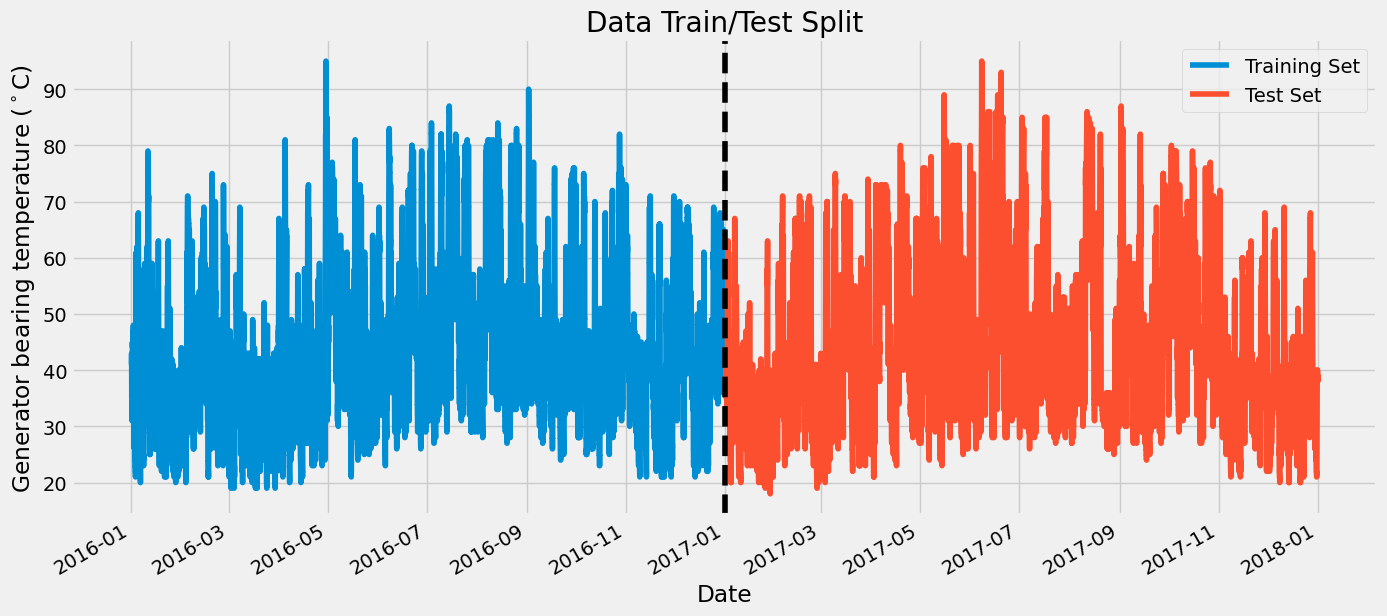

In [13]:
# Plot train/test split
train = df.loc[df.index < '2017']
test = df.loc[df.index >= '2017']

fig, ax = plt.subplots(figsize=(15,7))
train.Gen_Bear_Temp.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.Gen_Bear_Temp.plot(ax=ax, label='Test Set')
ax.axvline('2017', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
ax.set_ylabel('Generator bearing temperature ($^\circ$C)')
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))

plt.show()

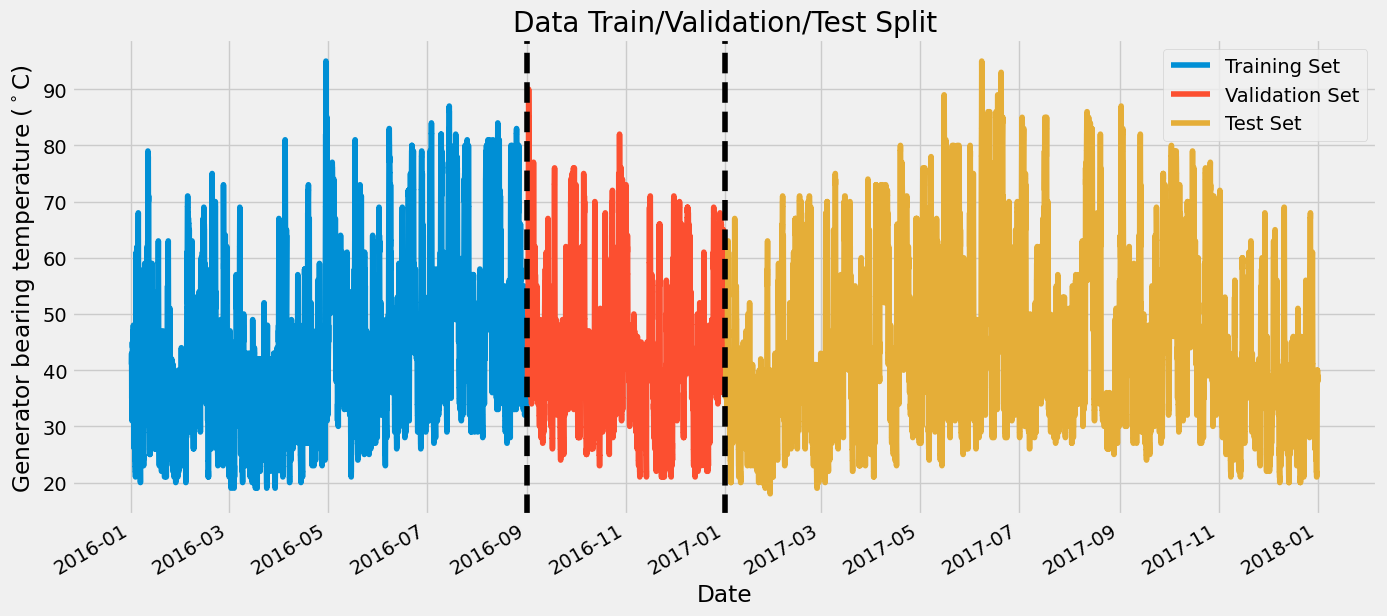

In [14]:
# Plot train/validation/test split
train = df.loc[df.index < '2016-09']
test = df.loc[df.index >= '2017']
cv = df.loc[(df.index >= '2016-09') & (df.index < '2017')]

fig, ax = plt.subplots(figsize=(15,7))
train.Gen_Bear_Temp.plot(ax=ax, label='Training Set', title='Data Train/Validation/Test Split')
cv.Gen_Bear_Temp.plot(ax=ax, label='Cross Validation Set')
test.Gen_Bear_Temp.plot(ax=ax, label='Test Set')
ax.axvline('2017', color='black', ls='--')
ax.axvline('2016-09', color='black', ls='--')
ax.legend(['Training Set', 'Validation Set', 'Test Set'])
ax.set_ylabel('Generator bearing temperature ($^\circ$C)')
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))

plt.show()

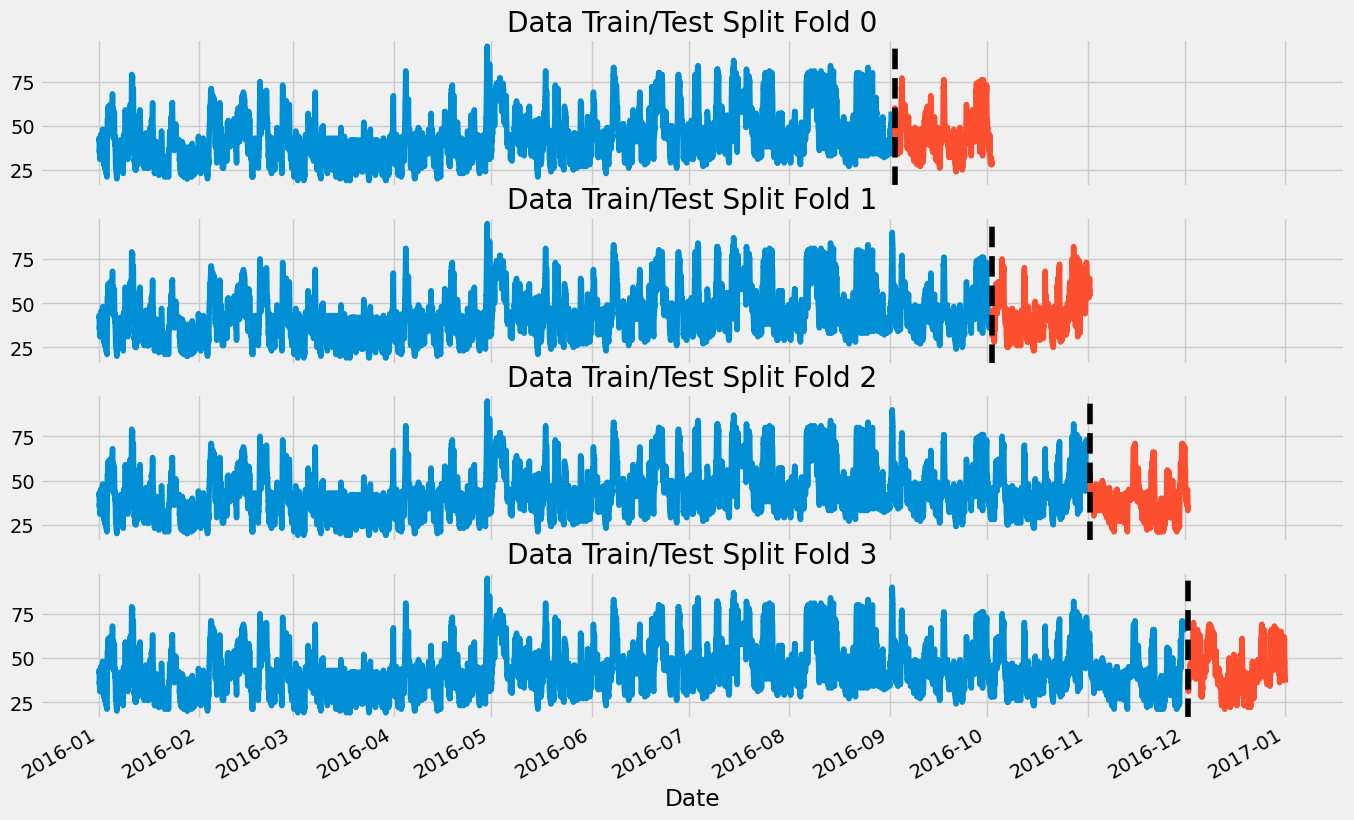

In [22]:
# Plot cross validation folds
tss = TimeSeriesSplit(n_splits=4, test_size=6*24*30, gap=6*24)

fig, axs = plt.subplots(4, 1, figsize=(15, 10), sharex=True)

cv_df = df.loc[df.index < '2017'].copy()

fold = 0
for train_idx, val_idx in tss.split(cv_df):
    train = cv_df.iloc[train_idx]
    test = cv_df.iloc[val_idx]
    train['Gen_Bear_Temp'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['Gen_Bear_Temp'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    axs[fold].xaxis.set_major_locator(mdates.MonthLocator())

    fold += 1

plt.show()

# Training and cv

In [3]:
# Train models
FEATURES = ['Gen_RPM', 'Gen_Phase_Temp', 'Nac_Temp', 'Wind_Speed', 'Humidity', 'Amb_Temp']
XGB, HGBR, LGB, XGB_dropped, RF_dropped, linear_dropped = train_models(FEATURES)

In [4]:
# Cross-validate NaN-compatible models
models = [XGB, HGBR, LGB]
CV(models)

XGB
Score across folds 1.47
Fold scores:['1.57', '1.63', '1.38', '1.32'] 

His
Score across folds 1.49
Fold scores:['1.53', '1.65', '1.40', '1.38'] 

LGB
Score across folds 1.49
Fold scores:['1.40', '1.75', '1.38', '1.42'] 



# Predictions

In [5]:
# Predicting and adding predictions to main dataframe
models = [XGB, HGBR, LGB, XGB_dropped, RF_dropped, linear_dropped]
FEATURES = ['Gen_RPM', 'Gen_Phase_Temp', 'Nac_Temp', 'Wind_Speed', 'Humidity', 'Amb_Temp']

df = predict(models, FEATURES)

In [6]:
# Make custom prediction with features in following order: 
#'Gen_RPM', 'Gen_Phase_Temp', 'Nac_Temp', 'Wind_Speed', 'Humidity','Gen_Phase_Temp'
XGB.predict(np.array([1000, 140, 70, 19, 47, 100]).reshape(1,-1))

array([80.27489], dtype=float32)

# Metrics

In [7]:
# Add metrics to dataframe
metrics = metric(df)

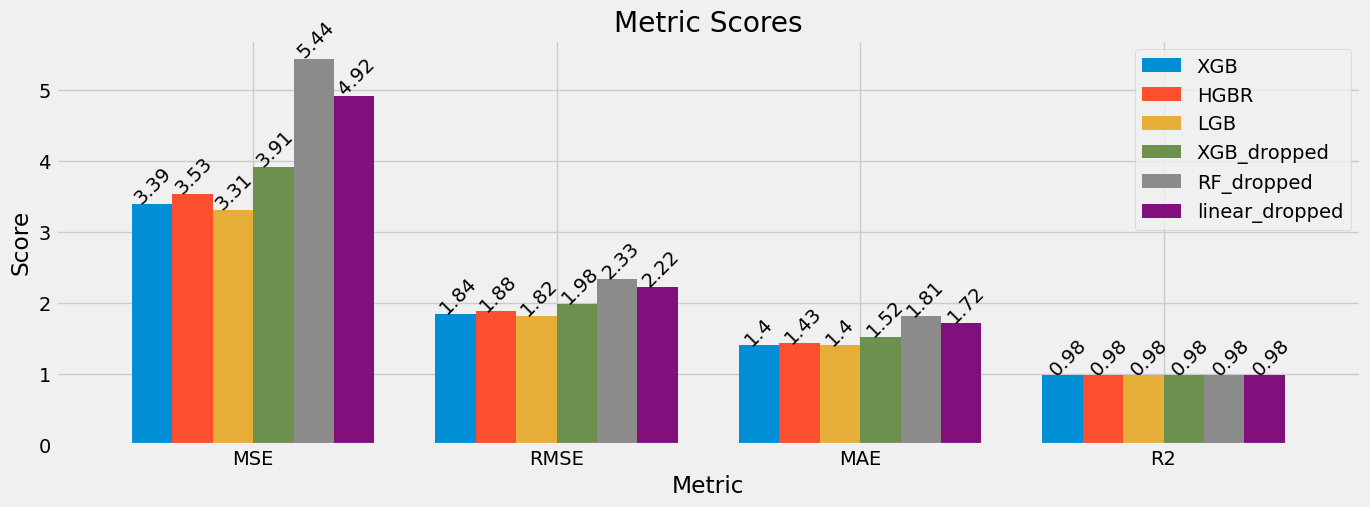

In [8]:
# Plot metrics
ax = metrics.drop(columns='MAPE').T.plot(kind='bar', figsize=(15,5), title='Metric Scores', xlabel='Metric', ylabel='Score', width=0.8)

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005), rotation=45)

plt.xticks(rotation=0)
plt.show()

# Hyperparameter tuning

In [ ]:
# GridSearch to tune hyperparameters of selected model
model = RF_dropped
param_grid = param_selection(model)

tss = TimeSeriesSplit(n_splits=4, test_size=6*24*30, gap=6*24)
search = GridSearchCV(model, param_grid, cv=tss, verbose=3, n_jobs=-1)

grid = best_params(search, model)
grid

In [ ]:
# XGB The best parameters are {'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 10, 'n_estimators': 500} with a score of 0.99
# HGBR The best parameters are {'learning_rate': 0.1, 'max_depth': 5, 'max_leaf_nodes': 10} with a score of 0.98
# LGB The best parameters are {'learning_rate': 0.1, 'max_depth': 3, 'min_data_in_leaf': 100, 'n_estimators': 600, 'num_leaves': 50} with a score of 0.99
# RF The best parameters are {'max_depth': 7, 'min_samples_leaf': 2, 'n_estimators': 100} with a score of 0.98

# Plotting predicted and actual values

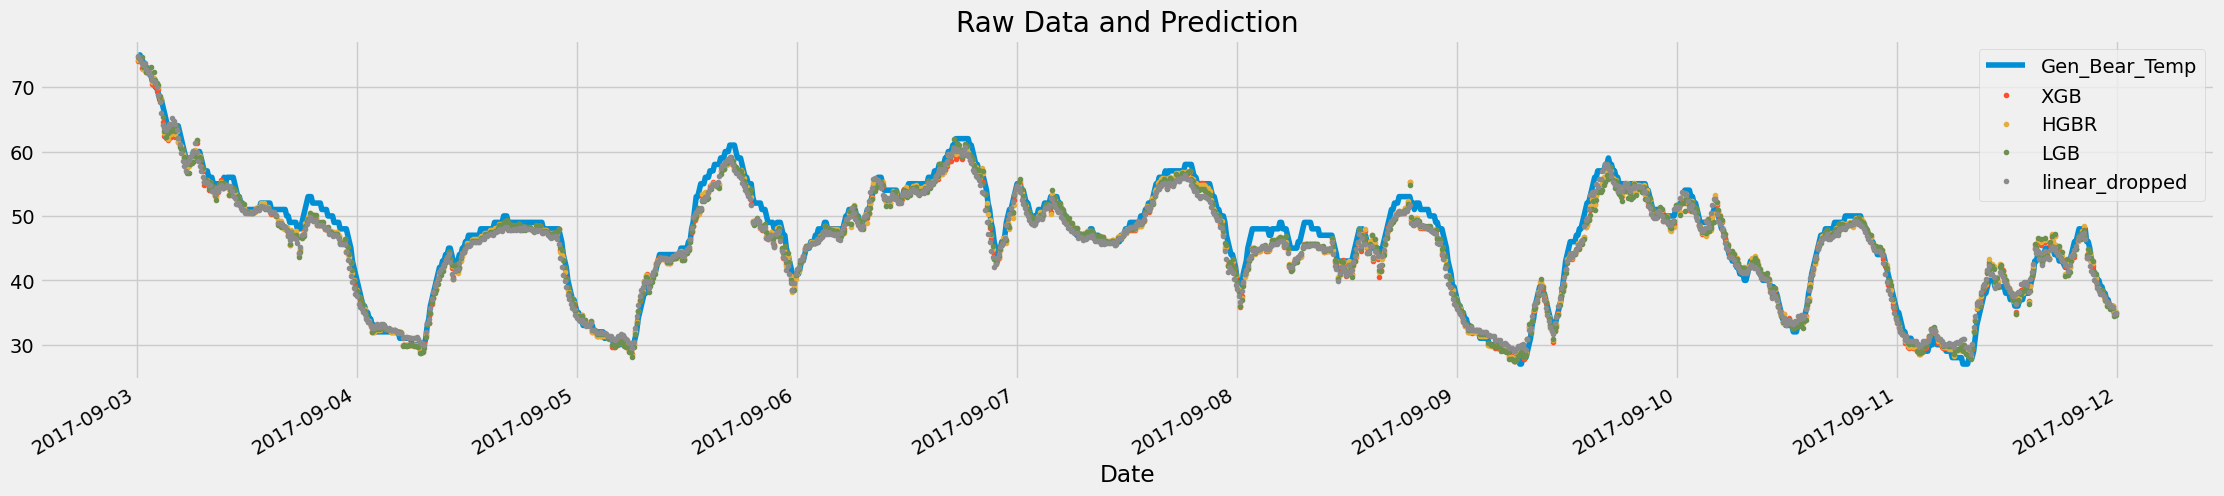

In [21]:
# Plot real value vs predicted values
start = '2017-09-03'
end = '2017-09-12'

ax = df.loc[(df.index > start) & (df.index < end)]['Gen_Bear_Temp'].plot(figsize=(25, 5), title='Raw Data and Prediction')

# Comment in or out models of interest
df.loc[(df.index > start) & (df.index < end)]['XGB'].plot(style='.')
df.loc[(df.index > start) & (df.index < end)]['HGBR'].plot(style='.')
df.loc[(df.index > start) & (df.index < end)]['LGB'].plot(style='.')
# df.loc[(df.index > start) & (df.index < end)]['XGB_dropped'].plot(style='.')
# df.loc[(df.index > start) & (df.index < end)]['RF_dropped'].plot(style='.')
df.loc[(df.index > start) & (df.index < end)]['linear_dropped'].plot(style='.')

plt.legend()
plt.show()

In [ ]:
df.query('index > "2017-06-07 19" & index < "2017-06-07 23"')

In [9]:
# Calculate error and show timestamps of largest errors
df = errors(df)

In [10]:
df.error_linear_dropped.sort_values(ascending=False).head(10)

Date
2017-06-07 21:00:00    15.429145
2017-06-07 21:10:00    15.248332
2017-06-07 21:20:00    14.274457
2017-06-07 23:00:00    14.244439
2017-06-07 22:10:00    14.181344
2017-06-19 21:50:00    14.103364
2017-06-07 23:30:00    14.032280
2017-06-07 22:00:00    14.020014
2017-06-07 23:10:00    14.013981
2017-06-07 21:30:00    13.920727
Name: error_linear_dropped, dtype: float64

In [131]:
model = linear_dropped

print("Model coefficients:\n")
for i in range(X.shape[1]):
    print(X.columns[i], "=", model.coef_[i].round(5))

Model coefficients:

Gen_RPM = -0.00142
Gen_Phase_Temp = 0.44766
Nac_Temp = 0.33883
Wind_Speed = 0.0293
Humidity = -0.00904
Amb_Temp = 0.19586


# Trying various tools to explain models

### Feature importance investigation

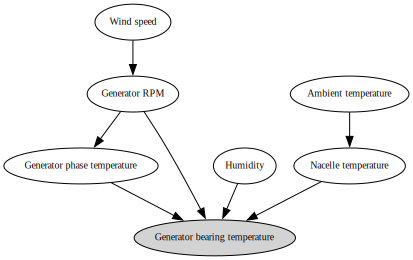

In [15]:
names = [
         "Wind speed", "Generator RPM", "Humidity", "Ambient temperature",
         "Nacelle temperature", "Generator phase temperature",
]
g = graphviz.Digraph()
for name in names:
    g.node(name, fontsize="10")
g.node("Generator bearing temperature", style="filled", fontsize="10")

g.edge("Wind speed", "Generator RPM")
g.edge("Generator RPM", "Generator phase temperature")
g.edge("Generator RPM", "Generator bearing temperature")
g.edge("Generator phase temperature", "Generator bearing temperature")
g.edge("Nacelle temperature", "Generator bearing temperature")
g.edge("Humidity", "Generator bearing temperature")
g.edge("Ambient temperature", "Nacelle temperature")

g

C:\Users\Oliver\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
C:\Users\Oliver\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


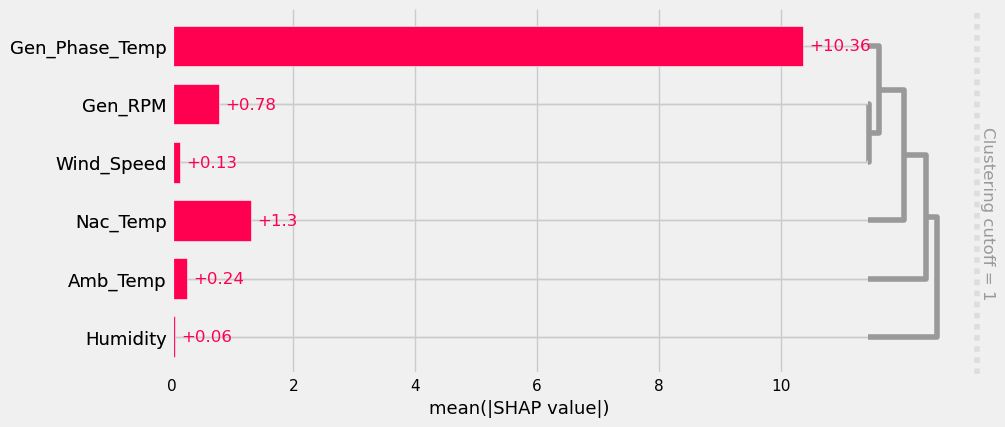

In [16]:
model = XGB
X = X_train[X_train['Humidity'].notna()][:1000]
y = y_train[X_train['Humidity'].notna()][:1000]

explainer = shap.Explainer(model)
shap_values = explainer(X)

clust = shap.utils.hclust(X, y, linkage="single")
shap.plots.bar(shap_values, clustering=clust, clustering_cutoff=1)

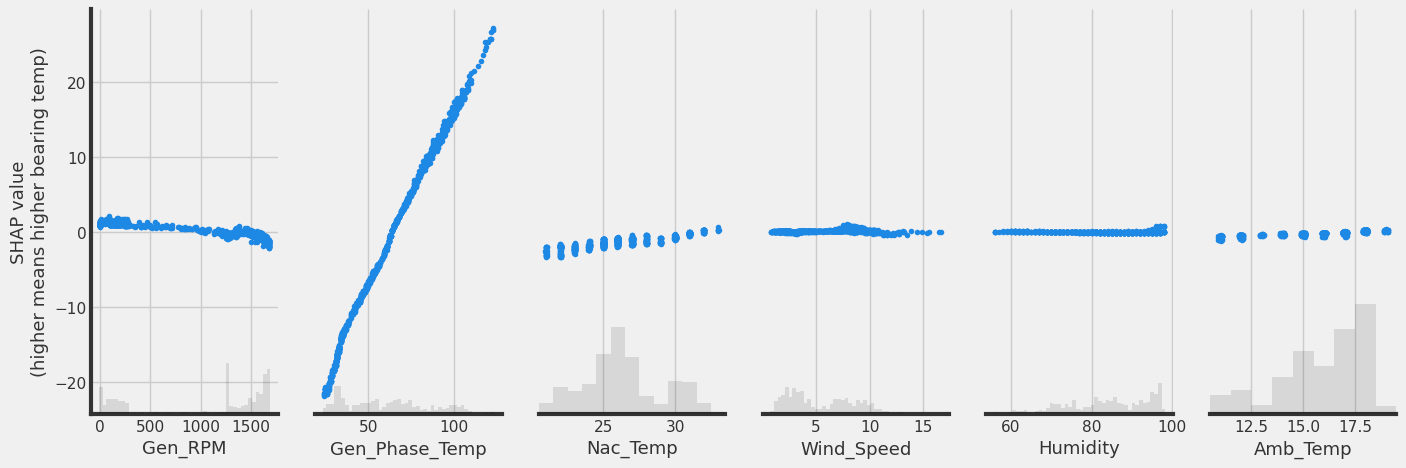

In [17]:
shap.plots.scatter(shap_values, ylabel="SHAP value\n(higher means higher bearing temp)")

### InterpretML

In [ ]:
from interpret.glassbox import ExplainableBoostingRegressor, LogisticRegression, LinearRegression, RegressionTree
from interpret.perf import RegressionPerf
from interpret.data import Marginal
from interpret import show

X = X_train[X_train['Humidity'].notna()][:5000]
y = y_train[X_train['Humidity'].notna()][:5000]

seed = 42

lr = LinearRegression(random_state=seed)
lr.fit(X, y)

rt = RegressionTree(random_state=seed)
rt.fit(X, y)

ebm = ExplainableBoostingRegressor(random_state=seed)
ebm.fit(X, y)

marginal = Marginal().explain_data(X, y, name = 'Train Data')
ebm_perf = RegressionPerf(ebm.predict).explain_perf(X_test.fillna(-1000), y_test, name='EBM')
lr_perf = RegressionPerf(lr.predict).explain_perf(X_test.fillna(-1000), y_test, name='Linear Regression')
rt_perf = RegressionPerf(rt.predict).explain_perf(X_test.fillna(-1000), y_test, name='Regression Tree')
ebm_global = ebm.explain_global(name='EBM')
lr_global = ebm.explain_global(name='Linear Regression')
rt_global = ebm.explain_global(name='Regression Tree')
ebm_local = ebm.explain_local(X_test[:100], y_test[:100], name='EBM')

show([marginal, lr_perf, lr_global, rt_perf, rt_global, ebm_perf, ebm_global, ebm_local])

In [ ]:
import shap
explainer = shap.KernelExplainer(blackbox_model.predict,data=X[:1000])
shap_values = explainer.shap_values(X_test[:100])

In [ ]:
import scipy as sp
import scipy.cluster
import shap

In [ ]:
refs = X.values[1:100]
cluster_matrix = shap.explainers.Partition(X)

In [ ]:
D = sp.spatial.distance.pdist(X.fillna(X.mean()).T, metric="correlation")
cluster_matrix = sp.cluster.hierarchy.complete(D)

In [ ]:
# plot the clustering
plt.figure(figsize=(15, 6))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
sp.cluster.hierarchy.dendrogram(
    cluster_matrix,
    leaf_rotation=0.,  # rotates the x axis labels
    leaf_font_size=10.,  # font size for the x axis labels
    labels=X.columns
)
plt.show()

In [ ]:
# define the model as a python function
f = lambda x: model.predict(x, output_margin=True, validate_features=False)

# explain the model
# pexplainer = shap.PartitionExplainer(f, refs, cluster_matrix)
# shap_values = pexplainer(x, npartitions=500)

m = shap.maskers.Independent(refs)
pexplainer = shap.explainers.(f, refs)
p2explainer = shap.explainers.Partition(f, m)

In [ ]:
from interpret import set_visualize_provider
from interpret.provider import InlineProvider
set_visualize_provider(InlineProvider())
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from interpret import show
from interpret.blackbox import ShapKernel
pca = PCA()
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1)

X = X_train[X_train['Humidity'].notna()]
y = y_train[X_train['Humidity'].notna()]

blackbox_model = Pipeline([('pca', pca), ('rf', rf)])
blackbox_model.fit(X.values, y)

shap = ShapKernel(predict_fn=blackbox_model.predict, data=X[:1000])
shap_local = shap.explain_local(X_test[:100], y_test[:100])

show(shap_local)

### EconML

In [17]:
import dowhy
from dowhy import CausalModel
import econml
from econml.dml import DML, LinearDML, CausalForestDML, SparseLinearDML
from econml.dr import LinearDRLearner
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import (Lasso, LassoCV, LogisticRegression,
                                  LogisticRegressionCV,LinearRegression,
                                  MultiTaskElasticNet,MultiTaskElasticNetCV)
from itertools import product
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures
import matplotlib
%matplotlib inline

In [18]:
# Generate controls, covariates, treatments and outcomes
scaler = StandardScaler()
W_train = X_train_dropped[[c for c in X_train_dropped.columns if c not in ['Wind_Speed', 'Gen_RPM']]].values
X_train = X_train_dropped[['Gen_RPM']].values
T_train = X_train_dropped["Wind_Speed"].values
Y_train = y_train_dropped.values

X_test = X_test_dropped[['Gen_RPM']].values

In [19]:
est = LinearDML(model_y=RandomForestRegressor(),
                model_t=RandomForestRegressor(),
                random_state=123)
est.fit(Y_train, T_train, X=X_train, W=W_train)
te_pred = est.effect(X_test)

In [20]:
est1 = SparseLinearDML(model_y=RandomForestRegressor(),
                       model_t=RandomForestRegressor(),
                       featurizer=PolynomialFeatures(degree=3),
                       random_state=123)
est1.fit(Y_train, T_train, X=X_train, W=W_train)
te_pred1 = est1.effect(X_test)

C:\Users\Oliver\anaconda3\lib\site-packages\econml\utilities.py:81: UserWarning: The number of features in the final model (< 5) is too small for a sparse model. We recommend using the LinearDML estimator for this low-dimensional setting.


In [21]:
est2 = DML(model_y=RandomForestRegressor(),
           model_t=RandomForestRegressor(),
           model_final=Lasso(alpha=0.1, fit_intercept=False),
           featurizer=PolynomialFeatures(degree=10),
           random_state=123)
est2.fit(Y_train, T_train, X=X_train, W=W_train)
te_pred2 = est2.effect(X_test)

C:\Users\Oliver\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.254e+05, tolerance: 8.553e+01


In [22]:
est3 = CausalForestDML(model_y=RandomForestRegressor(),
                       model_t=RandomForestRegressor(),
                       criterion='mse', n_estimators=1000,
                       min_impurity_decrease=0.001,
                       random_state=123)
est3.tune(Y_train, T_train, X=X_train, W=W_train)
est3.fit(Y_train, T_train, X=X_train, W=W_train)
te_pred3 = est3.effect(X_test)

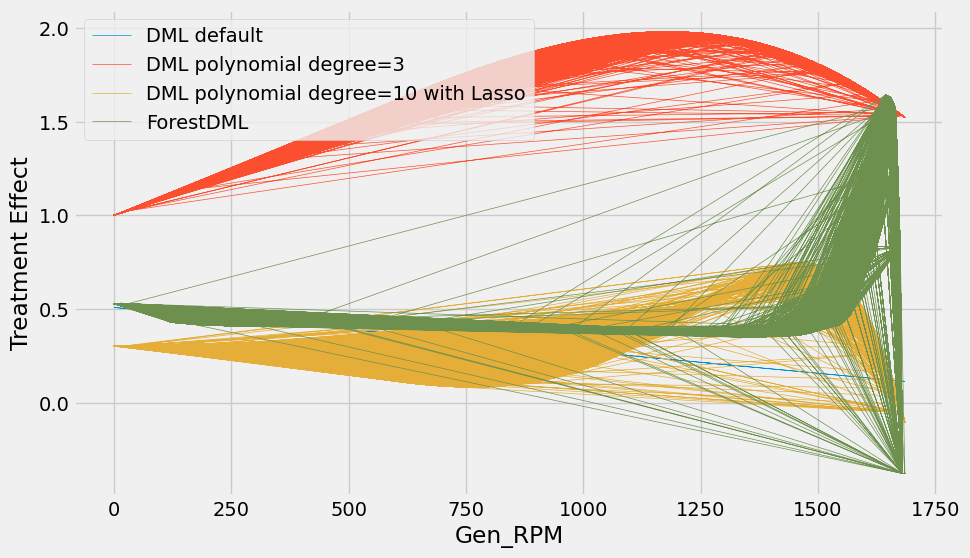

In [23]:
# Treatment effect function
plt.figure(figsize=(10,6))
plt.plot(X_test, te_pred, label='DML default', lw=0.5)
plt.plot(X_test, te_pred1, label='DML polynomial degree=3', lw=0.5)
plt.plot(X_test, te_pred2, label='DML polynomial degree=10 with Lasso', lw=0.5)
plt.plot(X_test, te_pred3, label='ForestDML', lw=0.5)
plt.ylabel('Treatment Effect')
plt.xlabel('Gen_RPM')
plt.legend()
plt.show()

In [ ]:
df[:10000].to_csv(r"CSV\forShowWhy.csv", index=False)

## SHAP

### Global explanations

In [8]:
from sklearn import linear_model
import time

X_test = test[:10000].dropna()[FEATURES]
y_test = test[:10000].dropna()[TARGET]

X_train_summary = shap.kmeans(X, 10)

def print_accuracy(f):
    print("Root mean squared test error = {0}".format(np.sqrt(np.mean((f(X_test) - y_test)**2))))
    time.sleep(0.5) # to let the print get out before any progress bars

shap.initjs()

In [9]:
lin_regr = linear_model.LinearRegression()
lin_regr.fit(X, y)

print_accuracy(lin_regr.predict)

Root mean squared test error = 3.7032262683386774


In [10]:
ex = shap.KernelExplainer(lin_regr.predict, X_train_summary)
shap_values = ex.shap_values(X_test.iloc[0,:])
shap.force_plot(ex.expected_value, shap_values, X_test.iloc[0,:])

C:\Users\Oliver\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
C:\Users\Oliver\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
C:\Users\Oliver\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names


In [ ]:
shap_values = ex.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

In [12]:
shap.force_plot(ex.expected_value, shap_values, X_test)

In [58]:
# Fits the explainer
# model = XGB
model1 = LGB
model2 = XGB
# X_test = X_test_dropped.copy()

title1 = str(model1)[:3]
title2 = str(model2)[:3]

explainer1 = shap.TreeExplainer(model1)
shap_values1 = explainer1.shap_values(X_test)

explainer2 = shap.TreeExplainer(model2)
shap_values2 = explainer2.shap_values(X_test)

C:\Users\Oliver\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.


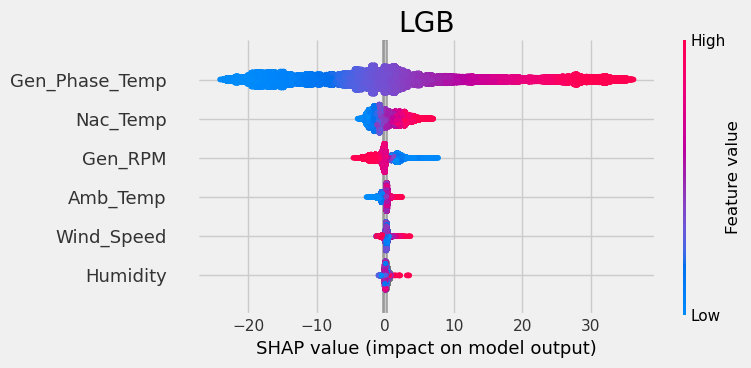

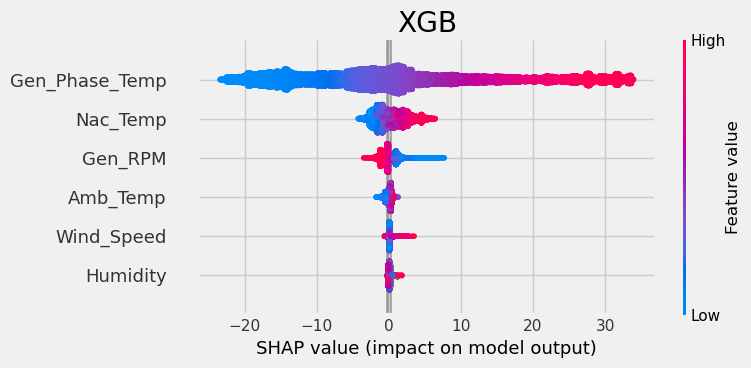

In [61]:
# Show global explanation
plt.title(title1)
shap.summary_plot(shap_values1, X_test)
plt.title(title2)
shap.summary_plot(shap_values2, X_test)

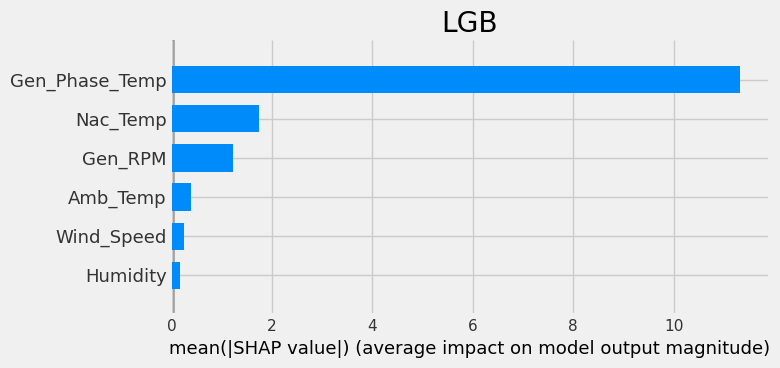

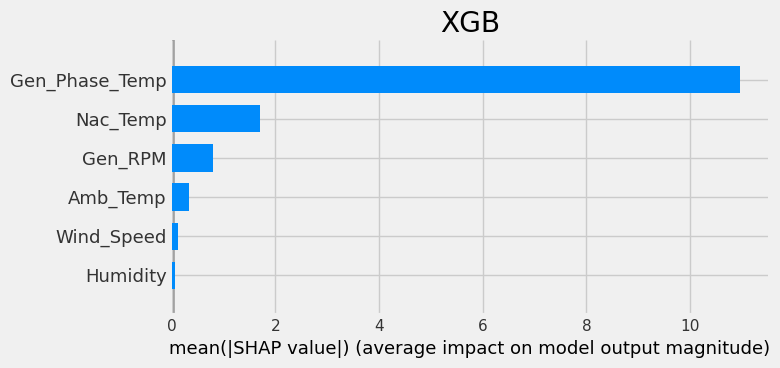

In [62]:
# Plot summary_plot as barplot:
plt.title(title1)
shap.summary_plot(shap_values1, X_test, plot_type='bar')
plt.title(title2)
shap.summary_plot(shap_values2, X_test, plot_type='bar')

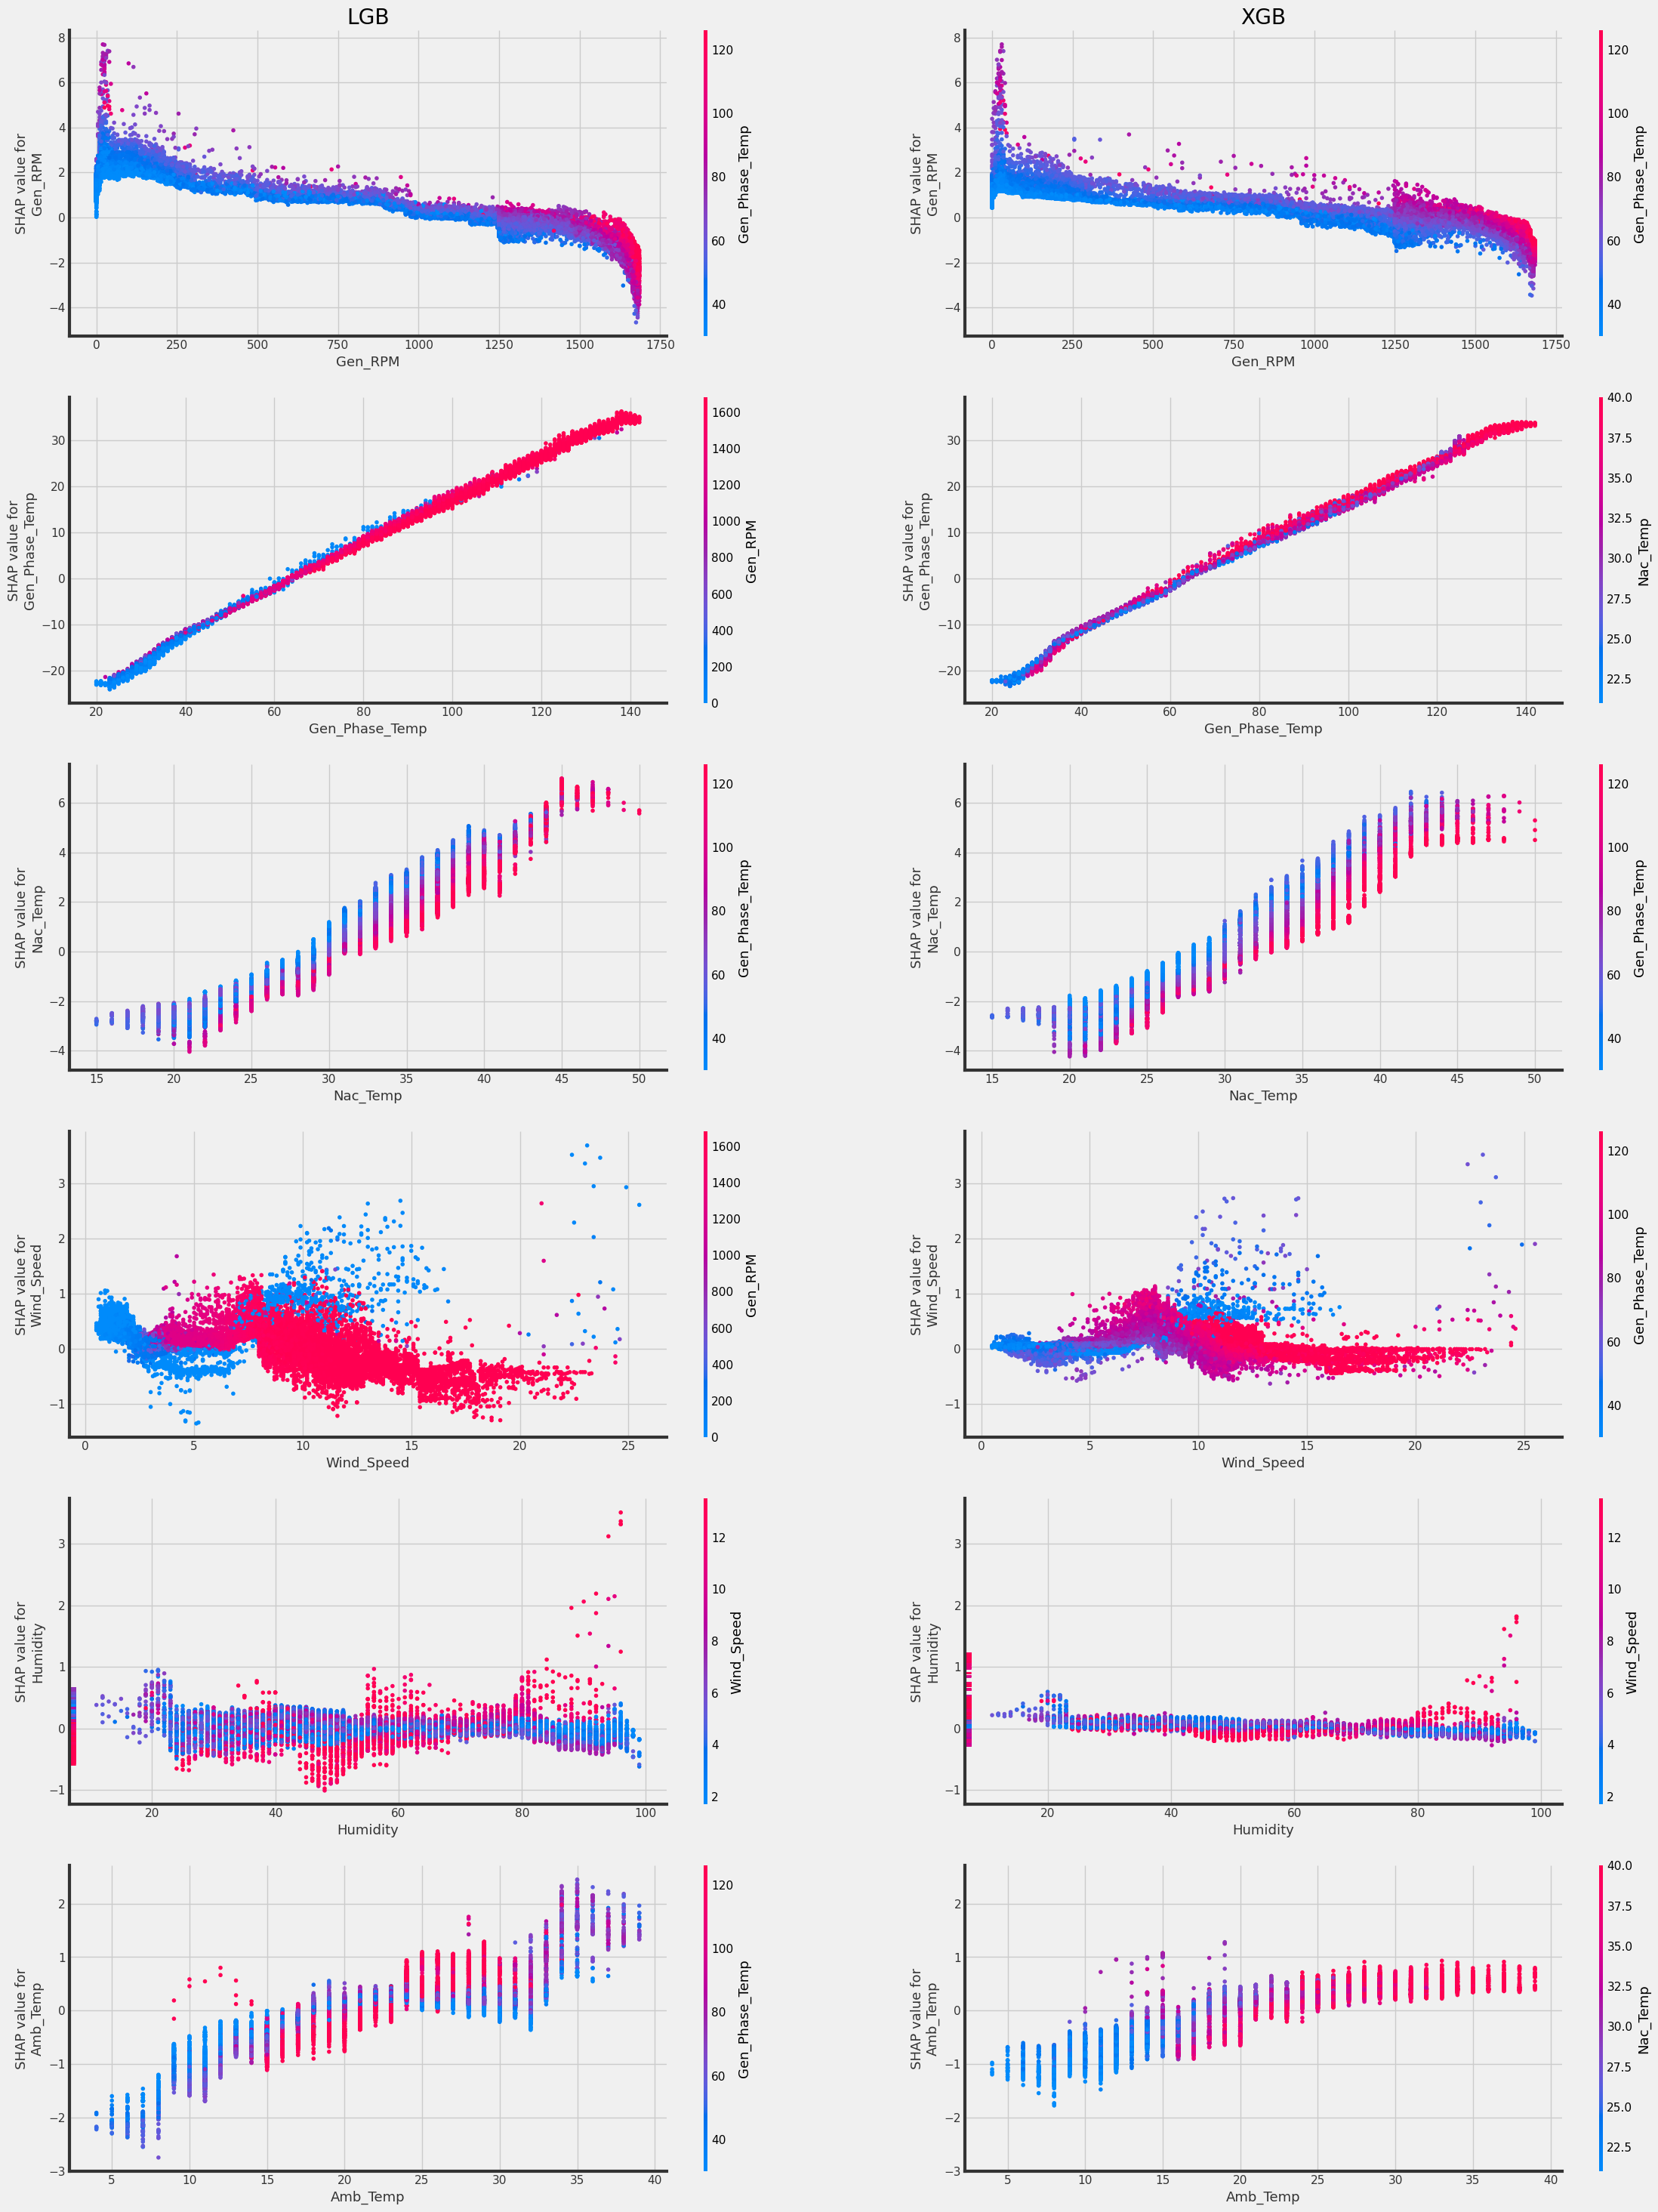

In [63]:
# Dependence plot:
columns = X_test.columns
#.drop('Gen_Phase_Temp')
fig, axs = plt.subplots(6,2, figsize=(25,35), sharey='row')

for i, col in enumerate(columns):
    shap.dependence_plot(col, shap_values1, X_test, ax=axs[i,0], show=False)
    shap.dependence_plot(col, shap_values2, X_test, ax=axs[i,1], show=False)

ax = axs[0,0].set_title(title1)
ax = axs[0,1].set_title(title2)

plt.show()

#interaction_index='Gen_Phase_Temp',
# shap.dependence_plot('Gen_Phase_Temp', shap_values, X_test_dropped, ax=axs[4,0], show=False)
# shap.dependence_plot('Gen_Phase_Temp', shap_values2, X_test_dropped, ax=axs[4,1], show=False)

### Interaction values

In [64]:
X_interaction = X_test.iloc[:4000,:]
shap_interaction_values1 = shap.TreeExplainer(model1).shap_interaction_values(X_interaction)
shap_interaction_values2 = shap.TreeExplainer(model2).shap_interaction_values(X_interaction)

LGB


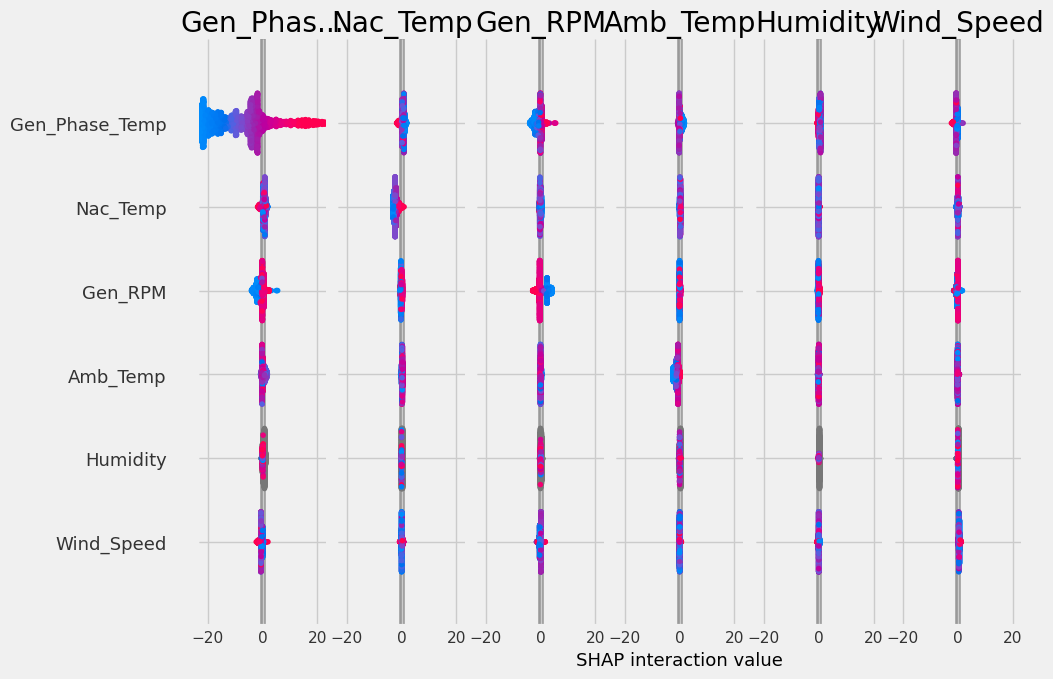

XGB


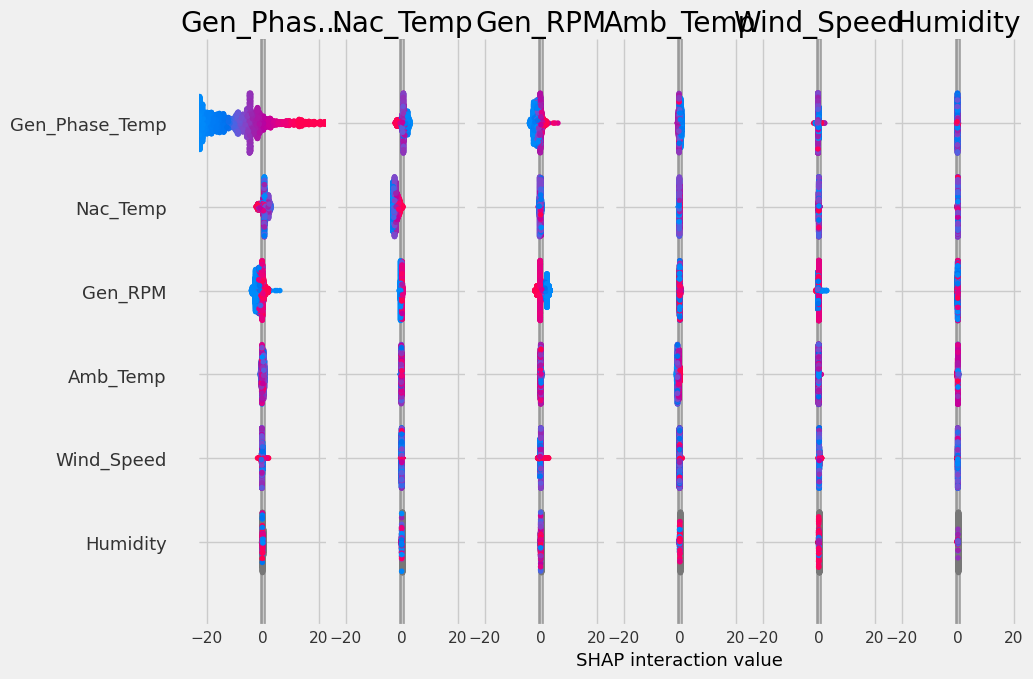

In [70]:
print(title1)
shap.summary_plot(shap_interaction_values1, X_interaction)
print(title2)
shap.summary_plot(shap_interaction_values2, X_interaction)

LGB


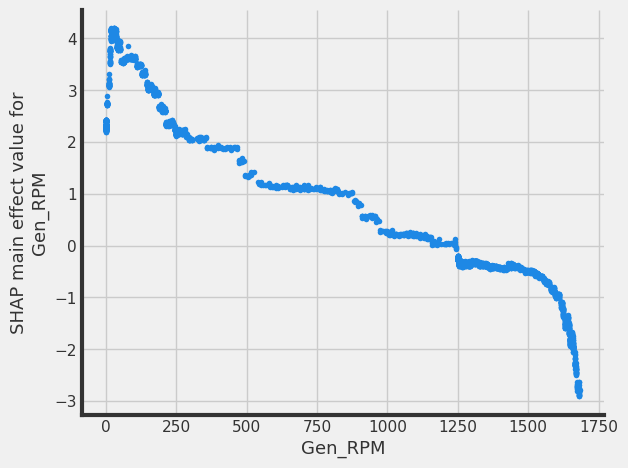

XGB


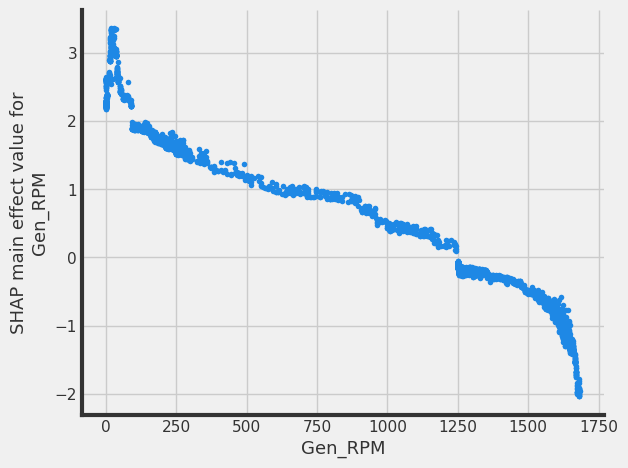

In [72]:
print(title1)
shap.dependence_plot(('Gen_RPM', 'Gen_RPM'), shap_interaction_values1, X_interaction, show=True)
print(title2)
shap.dependence_plot(('Gen_RPM', 'Gen_RPM'), shap_interaction_values2, X_interaction, show=False)

plt.show()

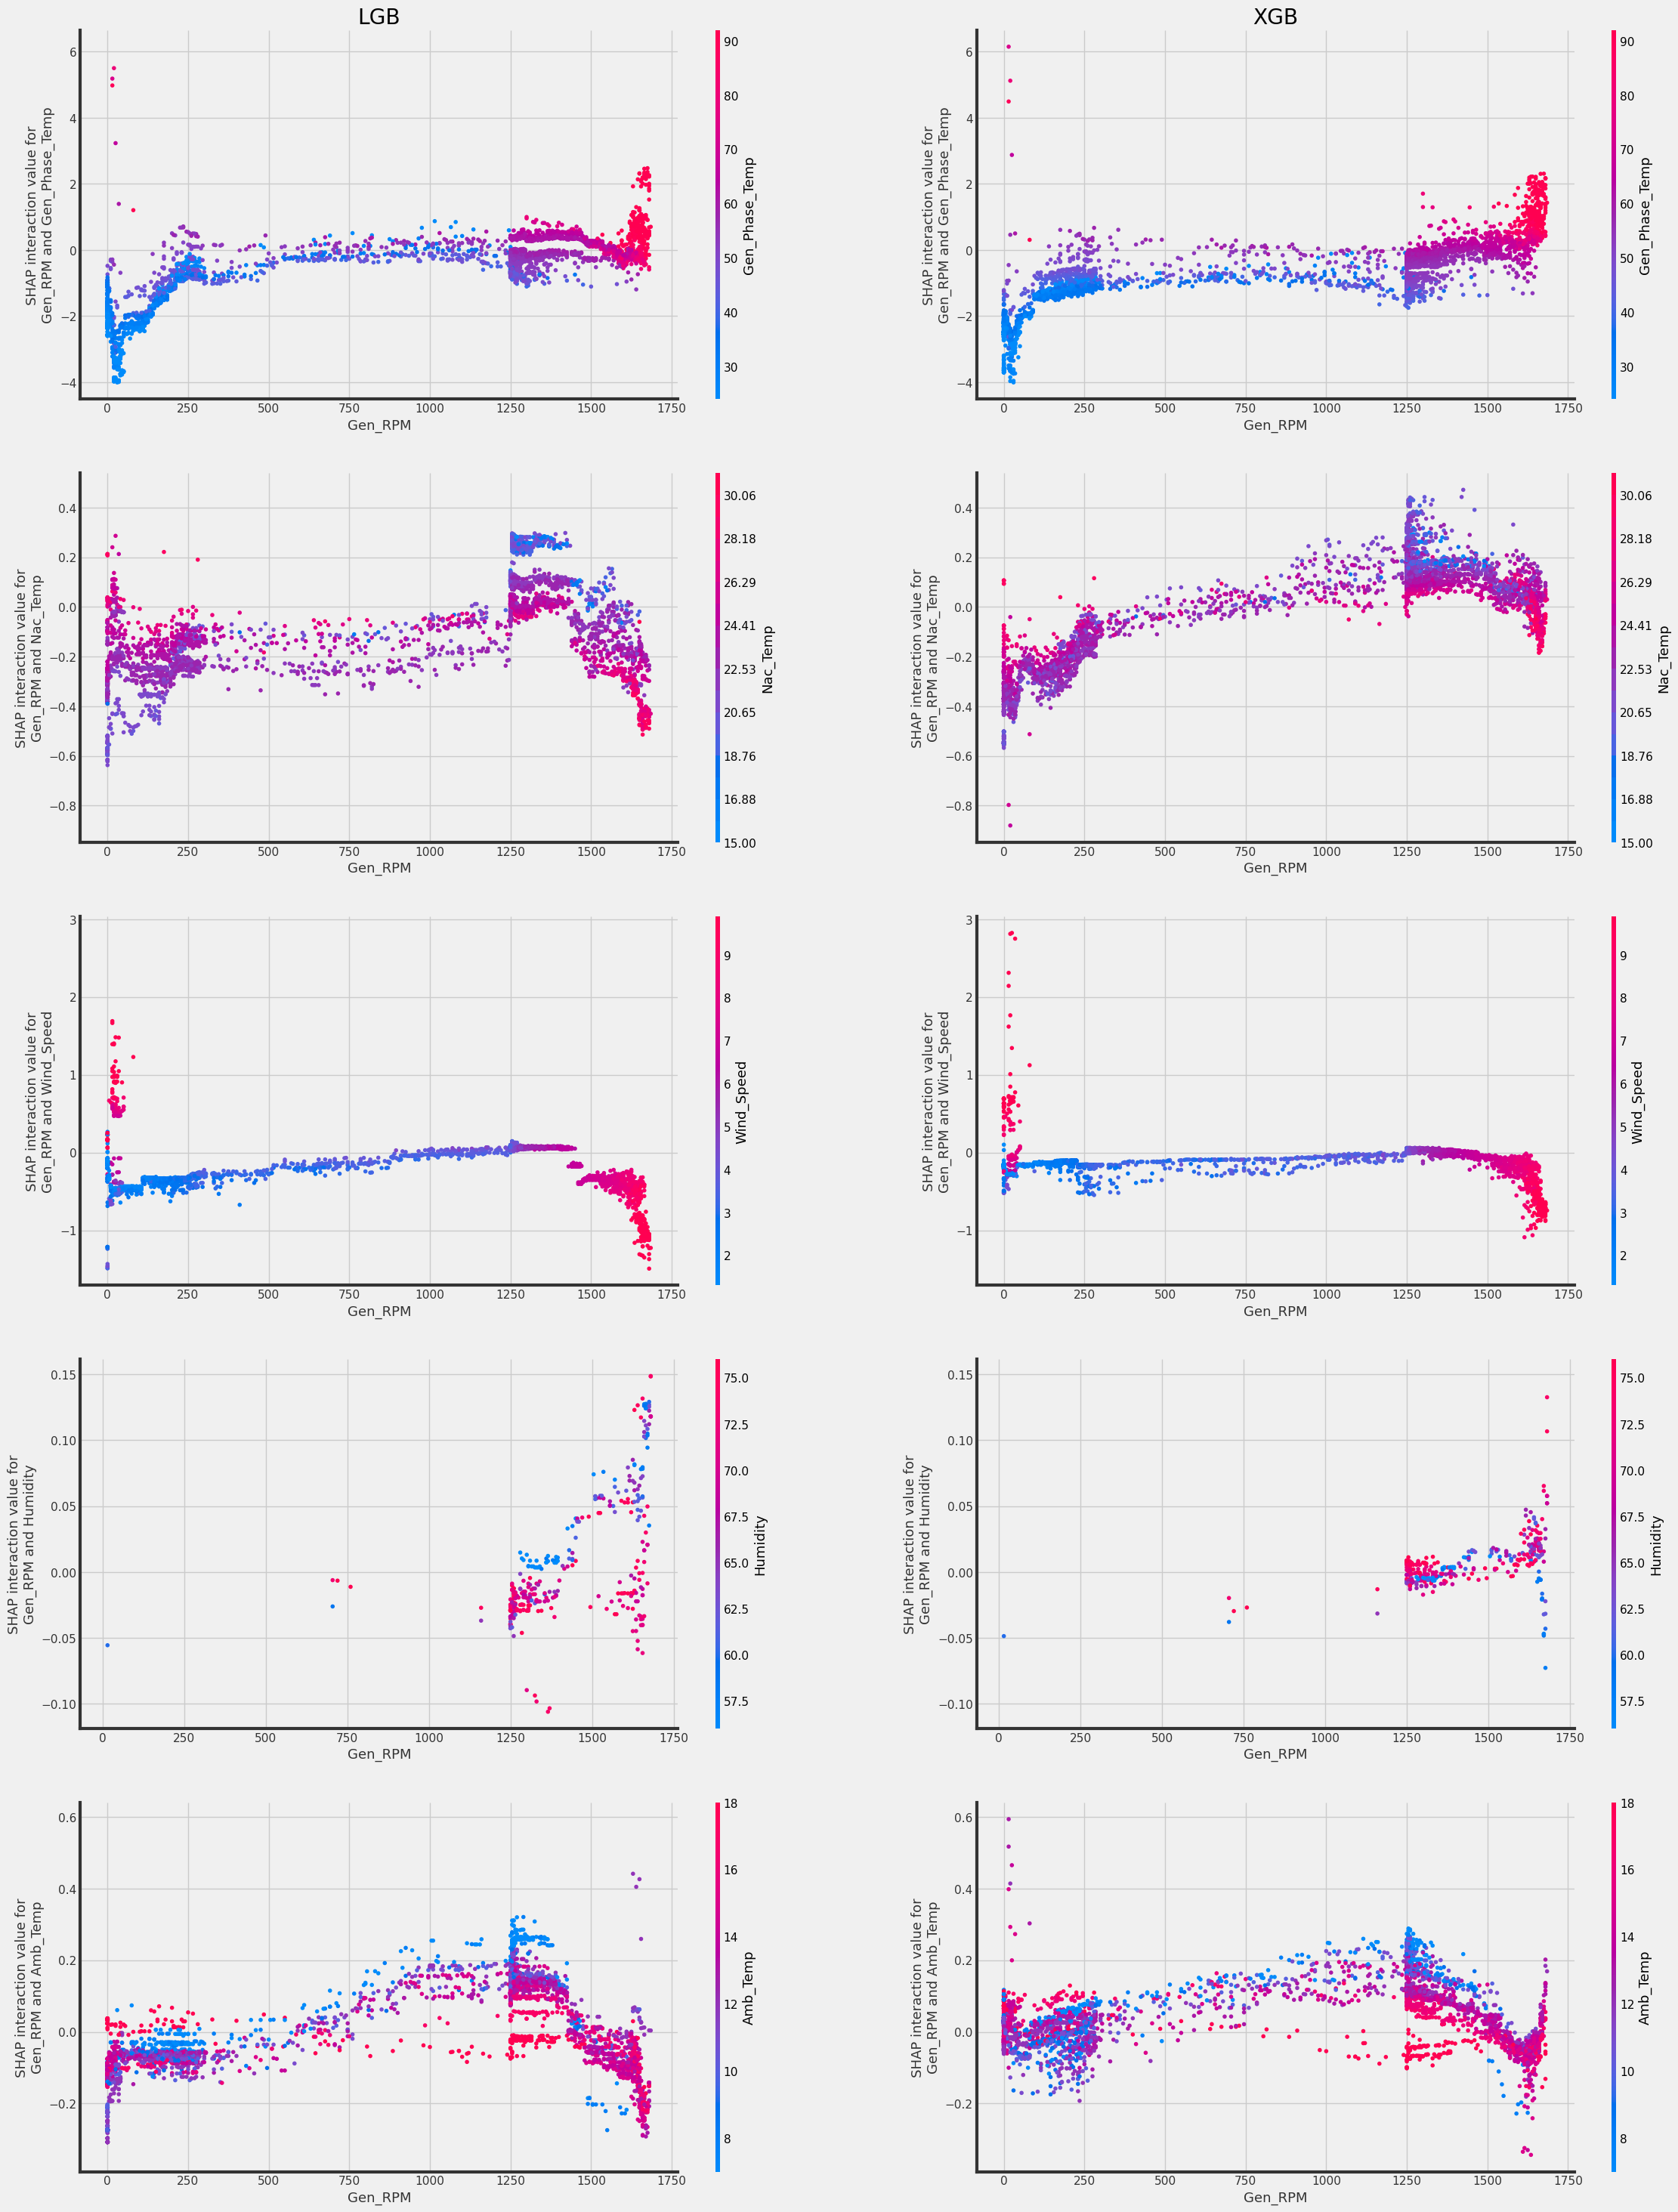

In [75]:
columns = X_test.columns.drop('Gen_RPM')
fig, axs = plt.subplots(5,2, figsize=(25,35), sharey='row')

for i, col in enumerate(columns):
    shap.dependence_plot(('Gen_RPM', col), shap_interaction_values1, X_interaction, ax=axs[i,0], show=False)
    shap.dependence_plot(('Gen_RPM', col), shap_interaction_values2, X_interaction, ax=axs[i,1], show=False)
    
ax = axs[0,0].set_title(title1)
ax = axs[0,1].set_title(title2)

plt.show()

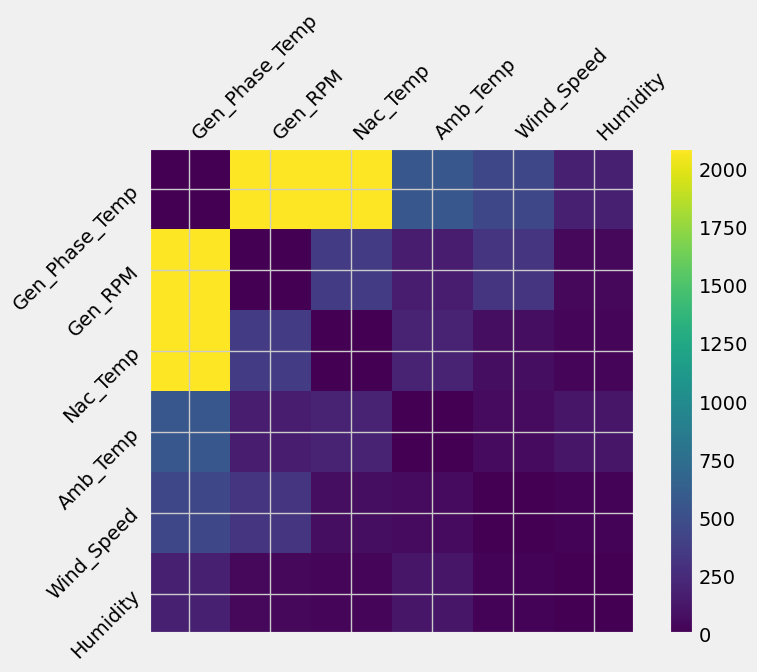

In [76]:
import matplotlib.pylab as pl
X = X_test
tmp = np.abs(shap_interaction_values2).sum(0)
for i in range(tmp.shape[0]):
    tmp[i,i] = 0
inds = np.argsort(-tmp.sum(0))[:50]
tmp2 = tmp[inds,:][:,inds]
pl.figure(figsize=(8,6))
pl.imshow(tmp2)
pl.yticks(range(tmp2.shape[0]), X.columns[inds], rotation=45, horizontalalignment="right")
pl.xticks(range(tmp2.shape[0]), X.columns[inds], rotation=45, horizontalalignment="left")
pl.gca().xaxis.tick_top()
pl.colorbar()
pl.show()

### Local explanations

In [77]:
import tempfile
from IPython.core.display import display, HTML

explainer = shap.TreeExplainer(XGB)
shap_values = explainer.shap_values(X_test)

shap.initjs()

def shap_deepnote_show(plot):
    tmp_output_filename = tempfile.NamedTemporaryFile(suffix='.html').name
    shap.save_html(tmp_output_filename, plot)

    f = open(tmp_output_filename, "r", encoding="utf-8")
    data = f.read()
    display(HTML(data))

<ipython-input-77-2d292aeb7644>:2: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
C:\Users\Oliver\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [78]:
shap_deepnote_show(shap.force_plot(explainer.expected_value, shap_values[535], X_test.iloc[535].values, feature_names = X_test.columns))

In [79]:
# X_interaction = X_test.iloc[:1000,:]

explainer = shap.TreeExplainer(XGB, X_interaction)
shap_values = explainer(X_interaction)

100%|===================| 3989/4000 [00:52<00:00]        

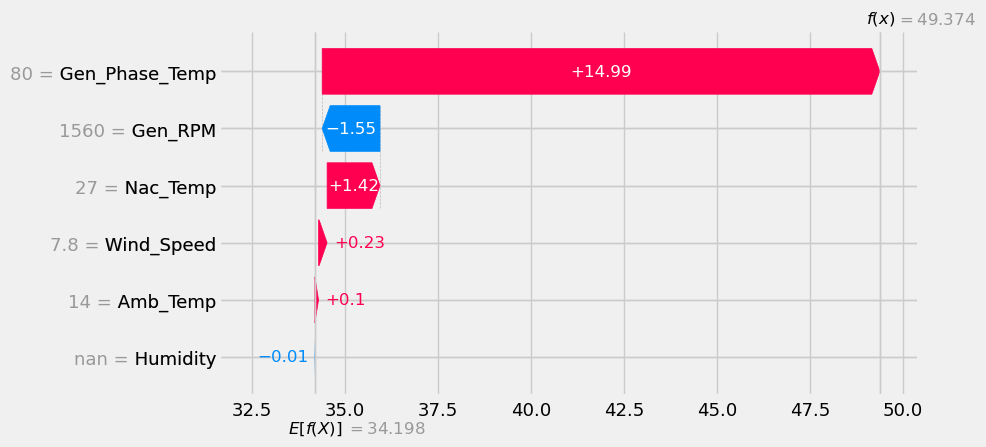

In [80]:
# Show local explanation
shap.plots.waterfall(shap_values[900,:])

# ALE

In [81]:
## two 1D plots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
ale_res_1 = ale(
    X=X[FEATURES],
    model=XGB,
    feature=["Gen_Phase_Temp"],
    feature_type="continuous",
    grid_size=20,
    include_CI=True,
    C=0.95,
    plot=True,
    fig=fig,
    ax=ax1,
)
ale_res_2 = ale(
    X=X[FEATURES],
    model=XGB,
    feature=["Gen_RPM"],
    feature_type="continuous",
    grid_size=20,
    include_CI=True,
    C=0.95,
    plot=True,
    fig=fig,
    ax=ax2,
)
# change x labels
ax1.set_xlabel("Temperature")
ax2.set_xlabel("RPM")

Text(0.5, 0, 'RPM')

In [82]:
# Plot two features and show their combiined effect on prediction
ale_eff = ale(X=X_test[FEATURES], model=model, feature=["Gen_Phase_Temp", "Gen_RPM"])

C:\Users\Oliver\anaconda3\lib\site-packages\PyALE\_src\ALE_2D.py:145: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
C:\Users\Oliver\anaconda3\lib\site-packages\PyALE\_src\ALE_2D.py:161: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().


C:\Users\Oliver\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.


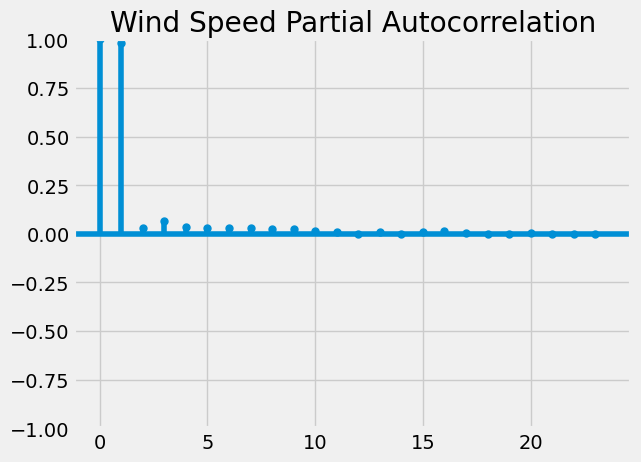

In [83]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(df.Wind_Speed, lags=23, missing='drop', title='Wind Speed Autocorrelation')

from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(df.Wind_Speed, lags=23, title='Wind Speed Partial Autocorrelation')

## dtreeviz

### Some lines are commented out due to them requiring a lot of CPU

In [ ]:
viz_rmodel = dtreeviz.model(XGB_dropped,
                           X_train_dropped, y_train_dropped,
                           feature_names=FEATURES,
                           target_name=TARGET,
                           tree_index=1                        
                          )

#viz_rmodel.view(fancy=False)

In [ ]:
x = X_train.iloc[20000]
x

In [ ]:
#viz_rmodel.view(show_just_path=True, x = x)

In [ ]:
#viz_rmodel.view(x = x)

In [ ]:
print(viz_rmodel.explain_prediction_path(x))

In [ ]:
viz_rmodel.leaf_sizes()

In [ ]:
viz_rmodel.rtree_leaf_distributions()

In [ ]:
viz_rmodel.node_stats(node_id=4)

# Lime

In [84]:
import lime
import lime.lime_tabular
explainer = lime.lime_tabular.LimeTabularExplainer(X_train.dropna().values, feature_names=X_train.columns.values.tolist(),
                                                  class_names=[TARGET], verbose=True, mode='regression')

In [85]:
j = 400
exp = explainer.explain_instance(X_test.values[j], XGB.predict, num_features=len(FEATURES))

Intercept 49.377451171314966
Prediction_local [30.19073877]
Right: 27.77129


In [86]:
exp.show_in_notebook(show_table=True)

In [87]:
exp.as_list()

[('Gen_Phase_Temp <= 42.00', -21.181371197733498),
 ('Gen_RPM <= 255.00', 2.8365870083220392),
 ('25.00 < Nac_Temp <= 29.00', -1.1778644198254484),
 ('18.00 < Amb_Temp <= 24.00', 0.4819094035744497),
 ('Humidity > 82.00', -0.10032702546631443),
 ('Wind_Speed <= 3.20', -0.04564617393485453)]

# ICE

In [88]:
import pycebox.ice as icebox
from pycebox.ice import ice, ice_plot
feat_importances = pd.Series(XGB.feature_importances_, index=X_train.columns)
feat_importances.sort_values(ascending=False).head()

Gen_Phase_Temp    0.934349
Nac_Temp          0.041637
Gen_RPM           0.010008
Amb_Temp          0.008090
Wind_Speed        0.004700
dtype: float32

In [89]:
def __get_quantiles(x):
    return np.greater.outer(x, x).sum(axis=1) / x.size
icebox.__get_quantiles = __get_quantiles

In [ ]:
ice_df = ice(X_test, 'Gen_RPM', XGB.predict, num_grid_points=100)

# Gen_RPM_ice_df = icebox.ice(data=X_test[:100], column='Gen_RPM', 
#                    predict=XGB.predict)
# # Plot the figure
# fig, ax = plt.subplots(figsize=(10, 10))
# plt.figure(figsize=(15, 15))
# icebox.ice_plot(Gen_RPM_ice_df, linewidth=.5,  plot_pdp=True, 
#          pdp_kwargs={'c': 'red', 'linewidth': 5}, ax=ax)
# ax.set_ylabel('Predicted Bearing Temperature')
# ax.set_xlabel('Gen_RPM')

fig, ax1 = plt.subplots(figsize=(10, 10))
plt.figure(figsize=(15, 15))
icebox.ice_plot(ice_df, linewidth=.5,  plot_pdp=True, 
         pdp_kwargs={'c': 'blue', 'linewidth': 5}, centered=True, ax=ax1)
ax1.set_ylabel('Predicted Bearing Temperature')
ax1.set_xlabel('Gen_RPM')

plt.show()
fig.show()

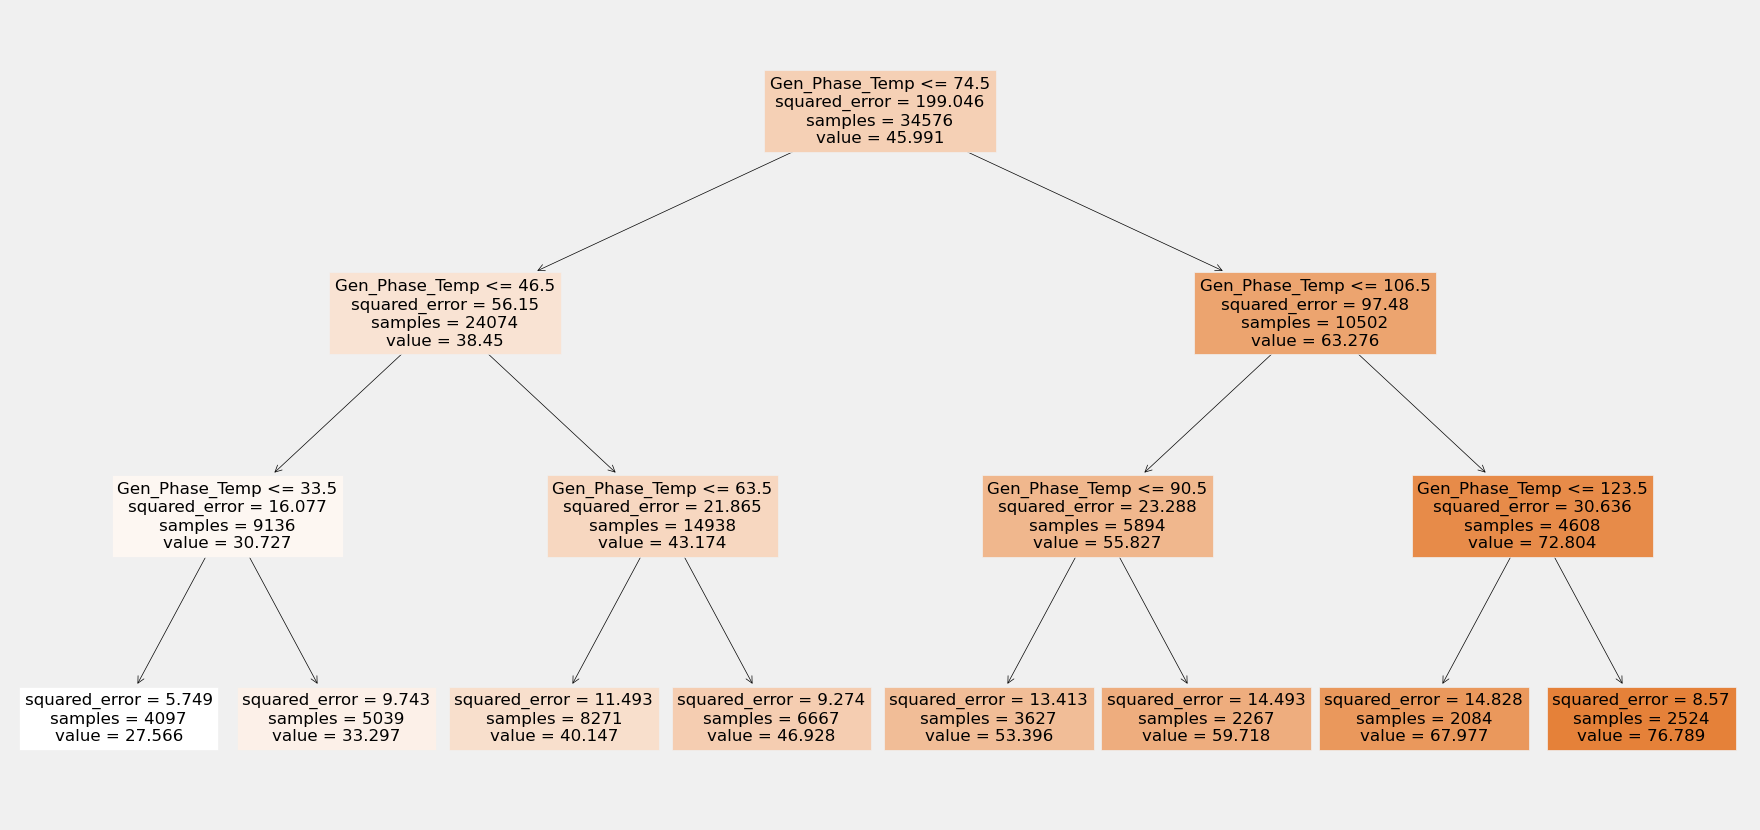

In [93]:
from sklearn.tree import DecisionTreeRegressor, plot_tree
predictions = XGB.predict(X_test_dropped)

dt = DecisionTreeRegressor(random_state = 100, max_depth=3)
dt.fit(X_test_dropped, predictions)

fig, ax = plt.subplots(figsize=(20, 10))
plot_tree(dt, feature_names=list(X_test.columns), precision=3, 
           filled=True, fontsize=12, impurity=True)
plt.show()

In [94]:
dt.score(X_test_dropped, predictions)

0.9471716328529955

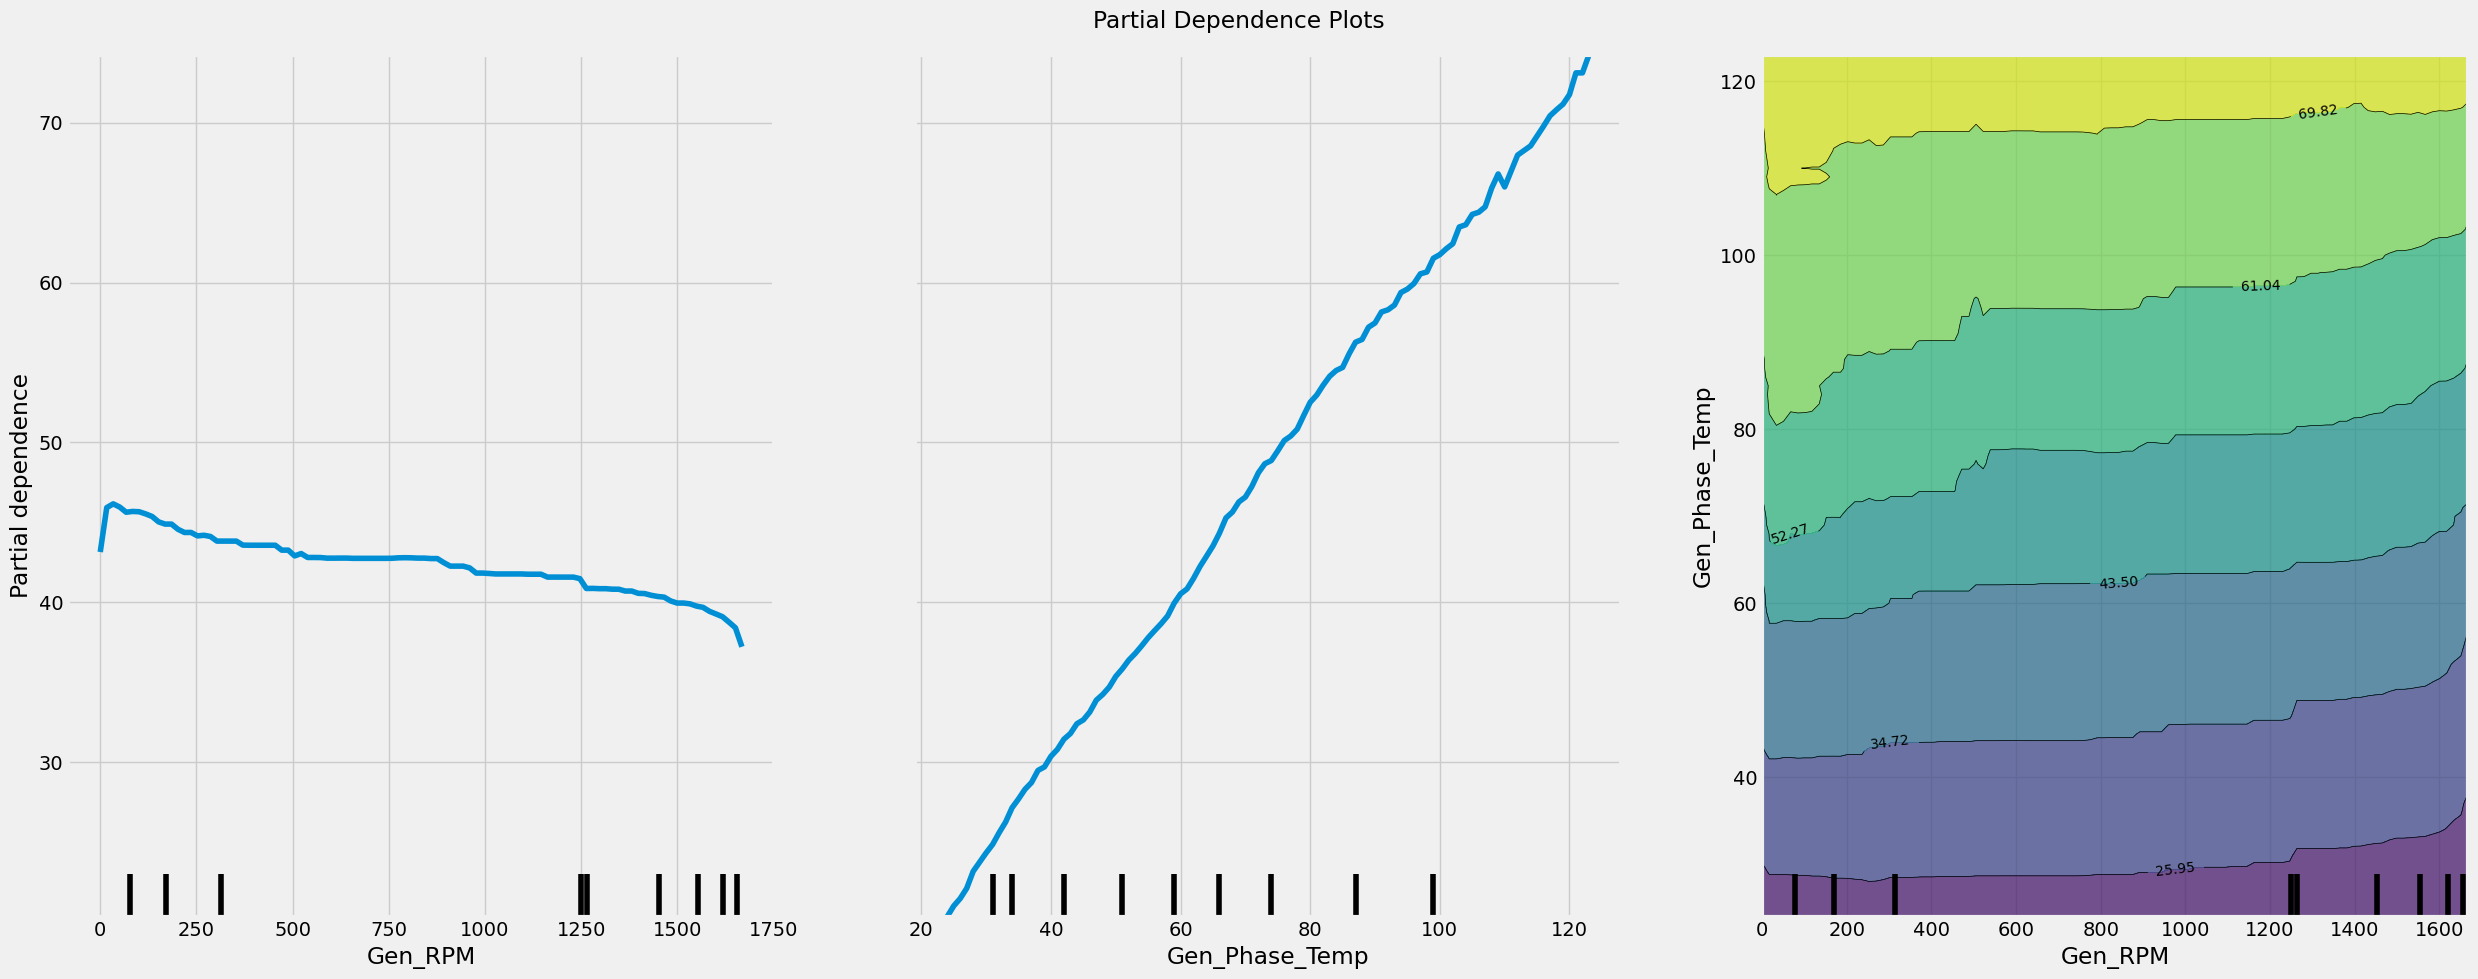

In [106]:
fig, ax = plt.subplots(figsize=(25, 10))
features = ['Gen_RPM', 'Gen_Phase_Temp', ('Gen_RPM', 'Gen_Phase_Temp')]
PartialDependenceDisplay.from_estimator(LGB, X_train[:100], features, ax=ax)
fig.suptitle('Partial Dependence Plots')
fig.tight_layout()
plt.show()

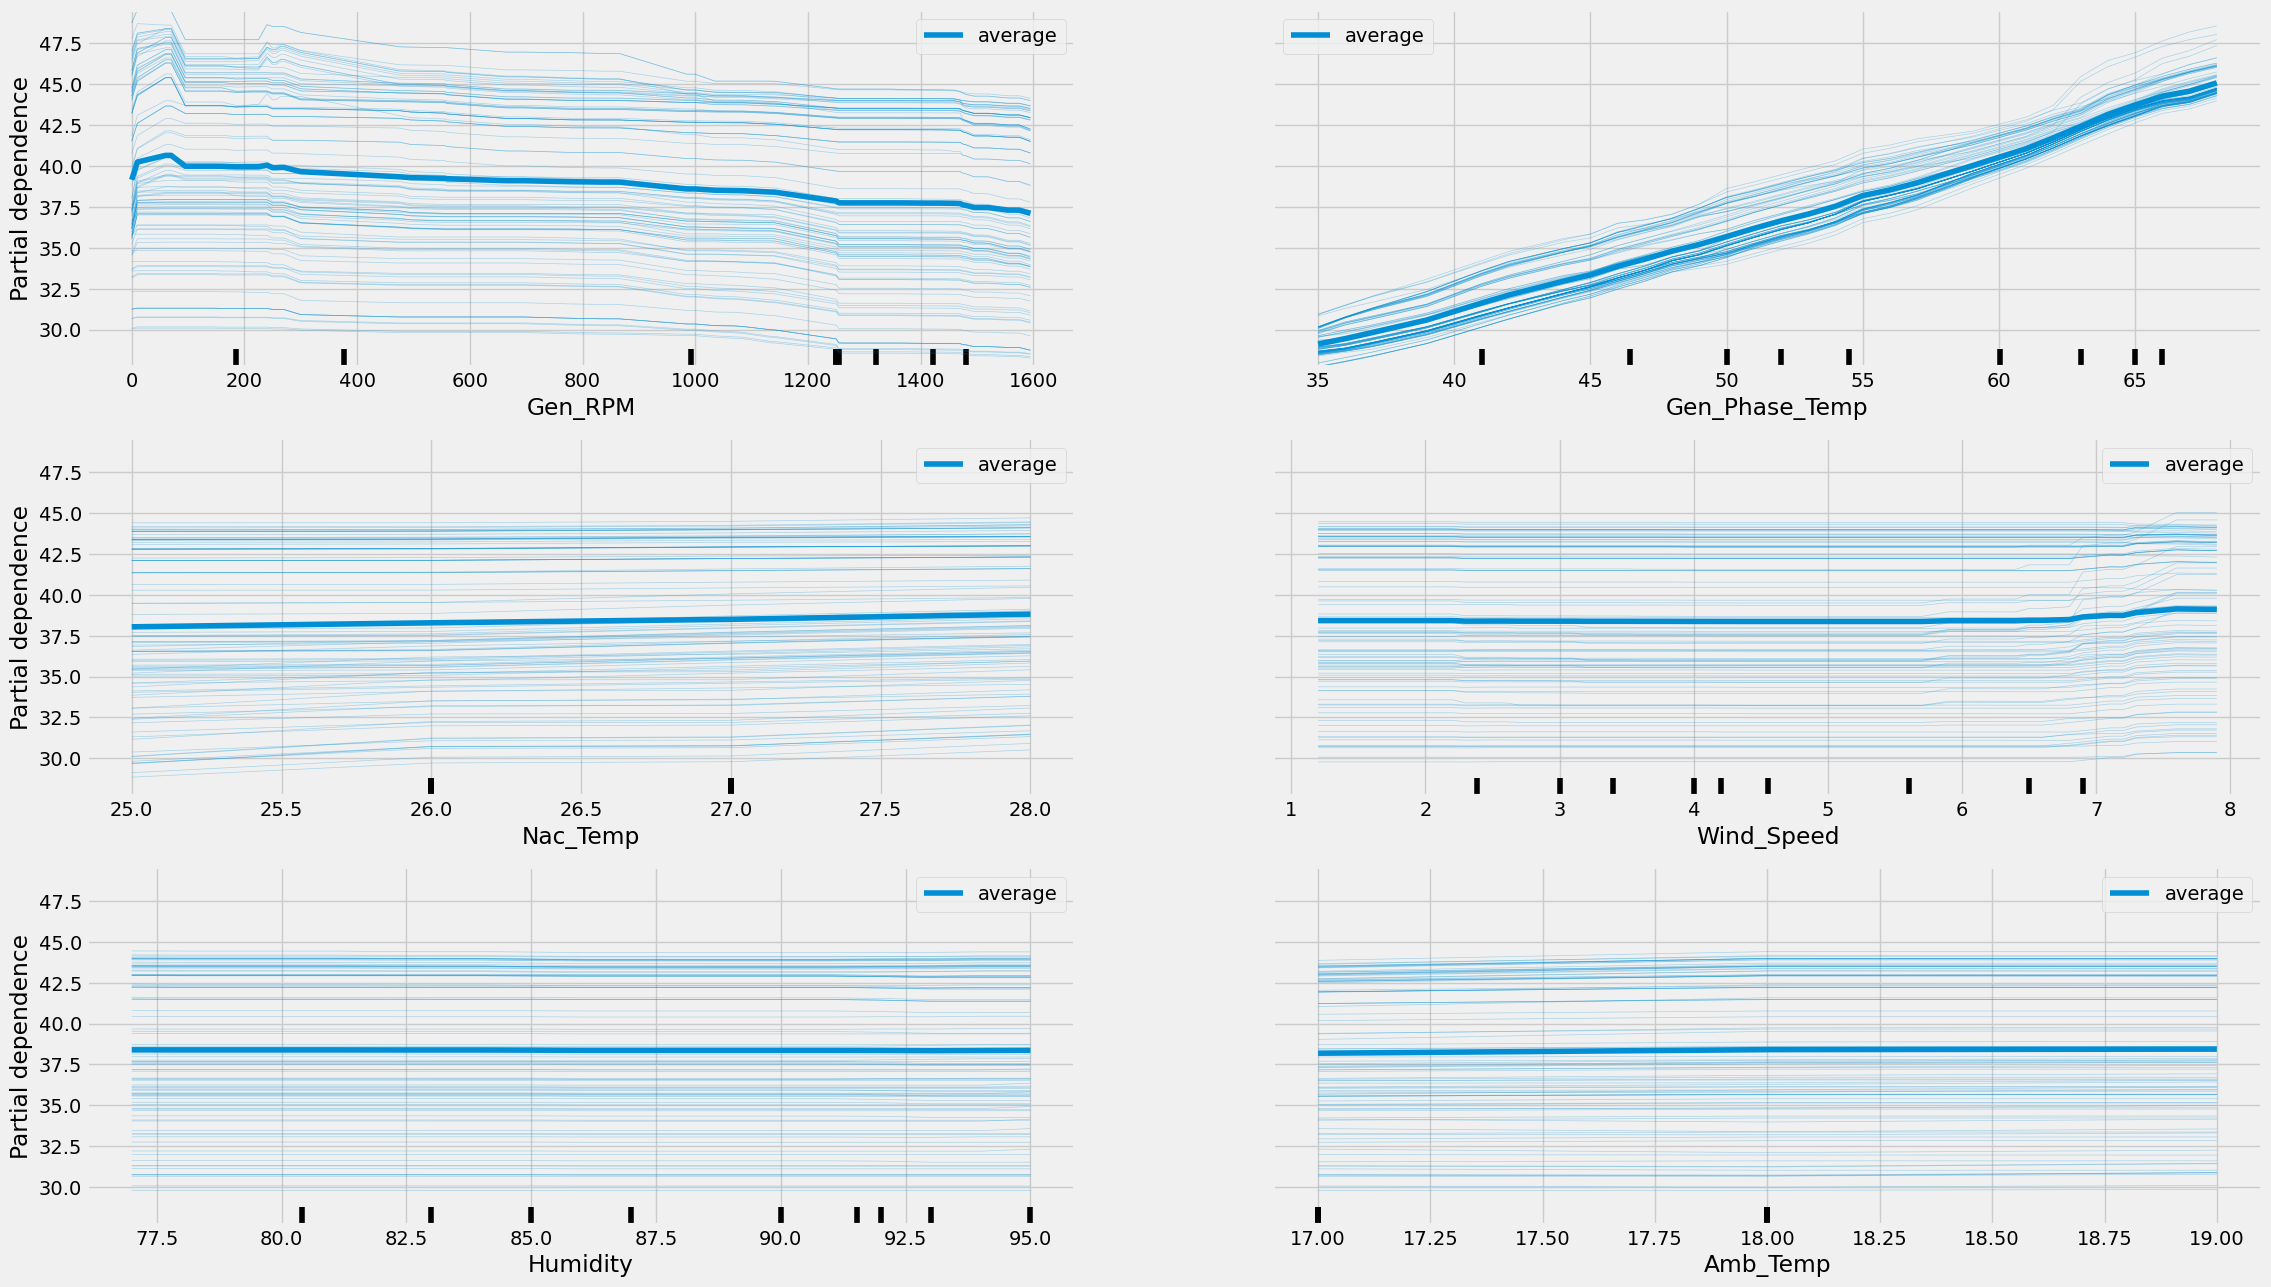

In [113]:
fig, ax = plt.subplots(3, 2, figsize=(25, 15))
PartialDependenceDisplay.from_estimator(XGB, X_train[:100], FEATURES,
    kind='both', ax=ax, n_cols=1
                                       )
plt.show()

In [ ]:
var = 'Gen_RPM'
values = X_train[var].sort_values().unique()

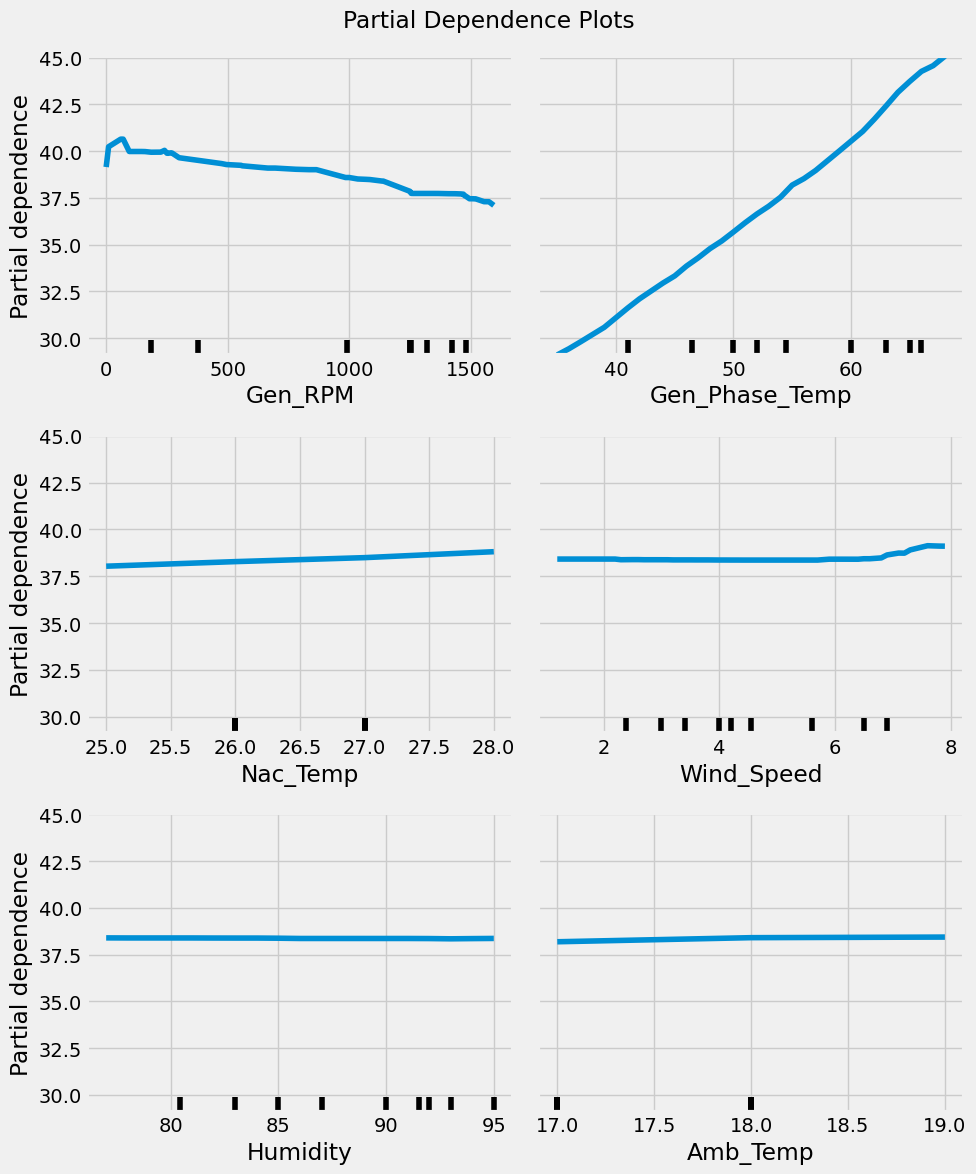

In [117]:
n_cols = 2
n_rows = int(len(X_train.columns)/n_cols)
fig, ax = plt.subplots(n_rows, n_cols, figsize=(10, 12))
PartialDependenceDisplay.from_estimator(XGB, X_train[:100], X_train.columns, ax=ax, n_cols=n_cols)
fig.suptitle('Partial Dependence Plots')
fig.tight_layout()
plt.show()

In [ ]:
#pd.set_option('display.max_rows', 500)
pd.reset_option('display.max_rows')
df.query('index >= "2017-12-06" & index < "2017-12-07"')

# Explainerdashboard

In [57]:
from explainerdashboard import RegressionExplainer, ExplainerDashboard

In [ ]:
model = ebm
explainer = RegressionExplainer(model, X_test[:1000], y_test[:1000],
                                target='Gen_Bear_Temp',
                                precision='float32')

db = ExplainerDashboard(explainer,title='WT Bearing Temperature Prediction', mode='external', )

In [ ]:
db.run()

In [ ]:
#db.to_yaml("dashboard.yaml", explainerfile="explainer.joblib", dump_explainer=True)
db = ExplainerDashboard.from_config("dashboard.yaml")
db.run()

In [ ]:
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import shap
from interpret import show
from interpret.blackbox import ShapKernel

pca = PCA()

blackbox_model = Pipeline([('pca', pca), ('xgb', XGB)])
blackbox_model.fit(X_train_dropped, y_train_dropped)

Shap = ShapKernel(predict_fn=blackbox_model.predict, data=shap.utils.sample(X_train_dropped, 1000))
shap_local = Shap.explain_local(X_test_dropped[10000:10020], y_test_dropped[10000:10020])

show(shap_local)